# **0. Import Libraries & Setup**

In [4]:
# Standard libraries
import os
from collections import Counter

# Data manipulation
from pandas.api.types import CategoricalDtype
import pandas as pd
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import seaborn as sns
from cycler import cycler

# Statistics
from scipy.stats import spearmanr, chi2_contingency

# Machine Learning
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

In [5]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [8]:
fm.fontManager.addfont("fonts/Poppins-Regular.ttf")
fm.fontManager.addfont("fonts/Poppins-Bold.ttf")

# Set default font family
mpl.rcParams['font.family'] = "Poppins"

In [9]:
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = '#808080'
mpl.rcParams['axes.labelcolor'] = '#808080'
mpl.rcParams['xtick.color'] = '#808080'
mpl.rcParams['ytick.color'] = '#808080'
mpl.rcParams['axes.edgecolor'] = '#808080'
mpl.rcParams['legend.labelcolor'] = '#808080'

palette_merah_putih = ["#FF4D4D",  "#CCCCCC", "#B30000", "#FF9999", "#FFFFFF"]
mpl.rcParams['axes.prop_cycle'] = cycler(color=palette_merah_putih)
sns.set_palette(palette_merah_putih)
cmap = LinearSegmentedColormap.from_list("merah_putih", ["#BFBFBF",  "#B30000"])

# **1. Load Dataset**

In [13]:
# Main dataset
app_train_df = pd.read_csv(r'home-credit-default-risk\application_train.csv')
app_test_df = pd.read_csv(r'home-credit-default-risk\application_test.csv')
print(f"Main train application data: {app_train_df.shape}")
print(f"Main test application data: {app_test_df.shape}")

# Related datasets
bureau_df = pd.read_csv(r'home-credit-default-risk\bureau.csv')
bureau_balance_df = pd.read_csv(r'home-credit-default-risk\bureau_balance.csv')
previous_app_df = pd.read_csv(r'home-credit-default-risk\previous_application.csv')
pos_cash_df = pd.read_csv(r'home-credit-default-risk\POS_CASH_balance.csv')
credit_card_df = pd.read_csv(r'home-credit-default-risk\credit_card_balance.csv')
installments_df = pd.read_csv(r'home-credit-default-risk\installments_payments.csv')

Main train application data: (307511, 122)
Main test application data: (48744, 121)


# **2. Feature Engineering**

## **2.1. Application Data**

In [14]:
app_train_df["CREDIT_ANNUITY_RATIO"] = app_train_df["AMT_CREDIT"] / (app_train_df["AMT_ANNUITY"] + 1e-9)
app_test_df["CREDIT_ANNUITY_RATIO"] = app_test_df["AMT_CREDIT"] / (app_test_df["AMT_ANNUITY"] + 1e-9)

## **2.2. Bureau Data**

In [15]:
# Aggregate bureau data per customer
bureau_agg = bureau_df.groupby("SK_ID_CURR").agg(
    BUREAU_DAYS_CREDIT_MEAN=("DAYS_CREDIT", "mean"),
    BUREAU_CREDIT_SUM=("AMT_CREDIT_SUM", "sum"),
    BUREAU_CREDIT_SUM_DEBT=("AMT_CREDIT_SUM_DEBT", "sum")
).reset_index()

# Compute debt-to-credit ratio (safe division)
bureau_agg["DEBT_CREDIT_RATIO"] = bureau_agg["BUREAU_CREDIT_SUM_DEBT"] / (
    bureau_agg["BUREAU_CREDIT_SUM"] + 1e-9
)

## **2.3. Previous Applications**

In [16]:
# Aggregate previous applications per customer
prev_app_agg = previous_app_df.groupby("SK_ID_CURR").agg(
    PREV_AMT_APP_MEAN=("AMT_APPLICATION", "mean"),
    PREV_AMT_CREDIT_MEAN=("AMT_CREDIT", "mean"),
    PREV_APPROVED_COUNT=("NAME_CONTRACT_STATUS", lambda x: (x == "Approved").sum()),
    PREV_REFUSED_COUNT=("NAME_CONTRACT_STATUS", lambda x: (x == "Refused").sum())
).reset_index()

## **2.4. Installment Payments**

In [17]:
# Compute payment ratio, replace infinities with 0, then aggregate mean ratio per customer
installments_df["PAYMENT_RATIO"] = installments_df["AMT_PAYMENT"] / installments_df["AMT_INSTALMENT"]
installments_df["PAYMENT_RATIO"] = installments_df["PAYMENT_RATIO"].replace([np.inf, -np.inf], 0)

installments_agg = installments_df.groupby("SK_ID_CURR").agg({"PAYMENT_RATIO": "mean"}).reset_index()
installments_agg.rename(columns={"PAYMENT_RATIO": "INST_PAYMENT_RATIO_MEAN"}, inplace=True)

## **2.5. POS Cash**

In [18]:
# Aggregate POS_CASH data: mean of future installments per customer
pos_cash_agg = pos_cash_df.groupby("SK_ID_CURR").agg(
    POS_INSTAL_FUTURE_MEAN=("CNT_INSTALMENT_FUTURE", "mean")
).reset_index()

## **2.6. Credit Card**

In [19]:
# Aggregate credit card data: mean balance per customer
credit_card_agg = credit_card_df.groupby("SK_ID_CURR").agg(
    CC_BALANCE_MEAN=("AMT_BALANCE", "mean")
).reset_index()

## **2.7. Merge All Data**

In [20]:
# Merge all aggregated features into train/test, select feature columns, and fill missing values with 0
agg_dfs = [bureau_agg, prev_app_agg, installments_agg, pos_cash_agg, credit_card_agg]
agg_dfs_test = [bureau_agg, prev_app_agg, installments_agg, pos_cash_agg, credit_card_agg]

final_train = app_train_df.copy()
for df in agg_dfs:
    final_train = final_train.merge(df, on="SK_ID_CURR", how="left")

final_test = app_test_df.copy()
for df in agg_dfs_test:
    final_test = final_test.merge(df, on="SK_ID_CURR", how="left")

print("Train final shape:", final_train.shape)
print("Test final shape:", final_test.shape)

feature_cols = [c for c in final_train.columns if any(p in c for p in ['BUREAU_', 'PREV_', 'INST_', 'POS_', 'CC_', 'CREDIT_'])]
final_train[feature_cols] = final_train[feature_cols].fillna(0)
final_test[feature_cols] = final_test[feature_cols].fillna(0)

Train final shape: (307511, 134)
Test final shape: (48744, 133)


## **2.8. Export Results**

In [21]:
# Save final datasets
final_train.to_csv('merged_credit_data_train.csv', index=False)
final_test.to_csv('merged_credit_data_test.csv', index=False)

print(f"Original train shape: {app_train_df.shape}")
print(f"Final train shape: {final_train.shape}")
print(f"Original test shape: {app_test_df.shape}")
print(f"Final test shape: {final_test.shape}")
print(f"New features added: {final_train.shape[1] - app_train_df.shape[1]}")

Original train shape: (307511, 123)
Final train shape: (307511, 134)
Original test shape: (48744, 122)
Final test shape: (48744, 133)
New features added: 11


In [22]:
# Sample of merged dataset
display(final_train.head())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ANNUITY_RATIO,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_SUM,BUREAU_CREDIT_SUM_DEBT,DEBT_CREDIT_RATIO,PREV_AMT_APP_MEAN,PREV_AMT_CREDIT_MEAN,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT,INST_PAYMENT_RATIO_MEAN,POS_INSTAL_FUTURE_MEAN,CC_BALANCE_MEAN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,16.461104,-874.00,865055.565,245781.0,0.284122,179055.00,179055.00,1.0,0.0,1.000000,15.000000,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,36.234085,-1400.75,1017400.500,0.0,0.000000,435436.50,484191.00

# **3. Exploratory Data Analysis (EDA)**

## **3.1. Overview Dataset**

In [23]:
# Print basic dataset information
print("BASIC DATASET INFO:")
print(f"Number of rows: {final_train.shape[0]:,}")
print(f"Number of columns: {final_train.shape[1]:,}")
print(f"Memory usage: {final_train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

BASIC DATASET INFO:
Number of rows: 307,511
Number of columns: 134
Memory usage: 533.1 MB


In [24]:
# Print summary of missing values
print("MISSING VALUES SUMMARY:")
missing_summary = final_train.isnull().sum()
missing_pct = (missing_summary / len(final_train)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

if len(missing_df) > 0:
    print(missing_df)

MISSING VALUES SUMMARY:
                              Missing Count  Missing %
COMMONAREA_AVG                       214865  69.872297
COMMONAREA_MODE                      214865  69.872297
COMMONAREA_MEDI                      214865  69.872297
NONLIVINGAPARTMENTS_MODE             213514  69.432963
NONLIVINGAPARTMENTS_AVG              213514  69.432963
NONLIVINGAPARTMENTS_MEDI             213514  69.432963
FONDKAPREMONT_MODE                   210295  68.386172
LIVINGAPARTMENTS_MEDI                210199  68.354953
LIVINGAPARTMENTS_MODE                210199  68.354953
LIVINGAPARTMENTS_AVG                 210199  68.354953
FLOORSMIN_MEDI                       208642  67.848630
FLOORSMIN_MODE                       208642  67.848630
FLOORSMIN_AVG                        208642  67.848630
YEARS_BUILD_MODE                     204488  66.497784
YEARS_BUILD_AVG                      204488  66.497784
YEARS_BUILD_MEDI                     204488  66.497784
OWN_CAR_AGE                          2029

## **3.2. Target Distribution**

In [25]:
# Generate summary statistics for TARGET
target_summary = final_train[["TARGET"]].describe(percentiles=[.25, .5, .75]).T
target_summary["Missing %"] = final_train["TARGET"].isnull().mean() * 100
display(target_summary)

,count,mean,std,min,25%,50%,75%,max,Missing %
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0,0.0


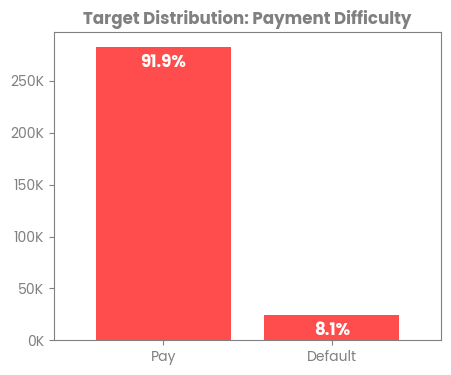

In [26]:
# Plot bar chart of target distribution with counts (in K) and percentage labels
plt.figure(figsize=(5,4))

ax = final_train["TARGET"].value_counts().plot(kind='bar', width=0.8)
plt.title('Target Distribution: Payment Difficulty')
plt.xlabel('')
plt.xticks(ticks=[0, 1], labels=['Pay', 'Default'], rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

total = final_train["TARGET"].shape[0]
for patch in ax.patches:
    height = patch.get_height()
    percentage = height / total * 100
    ax.text(patch.get_x() + patch.get_width()/2, height - 7_000, f'{percentage:.1f}%', ha='center', va='top', color='white', fontsize=12, fontweight='bold')

plt.show()

## **3.3. Customer Demographic Analysis**

In [27]:
# Demographic and personal columns
demographic_cols = ['CODE_GENDER', 'CNT_CHILDREN', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH', 'NAME_INCOME_TYPE']
demographic_cols = [col for col in demographic_cols if col in final_train.columns]

num_cols = final_train[demographic_cols].select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = final_train[demographic_cols].select_dtypes(include=['object','category']).columns.tolist()

display(final_train[num_cols + ['TARGET']].groupby('TARGET').describe())
display(final_train[cat_cols + ['TARGET']].groupby('TARGET').describe())

CNT_CHILDREN                                               DAYS_BIRTH  \
              count      mean       std  min  25%  50%  75%   max      count   
TARGET                                                                         
0          282686.0  0.412946  0.718843  0.0  0.0  0.0  1.0  19.0   282686.0   
1           24825.0  0.463807  0.756903  0.0  0.0  0.0  1.0  11.0    24825.0   

                                                                                
                mean          std      min       25%      50%      75%     max  
TARGET                                                                          
0      -16138.176397  4364.200856 -25229.0 -19793.75 -15877.0 -12536.0 -7489.0  
1      -14884.828077  4192.844583 -25168.0 -18037.00 -14282.0 -11396.0 -7678.0

CODE_GENDER                    NAME_FAMILY_STATUS                  \
             count unique top    freq              count unique      top   
TARGET                                                                     
0           282686      3   F  188278             282686      6  Married   
1            24825      2   F   14170              24825      5  Married   

               NAME_EDUCATION_TYPE                                        \
          freq               count unique                            top   
TARGET                                                                     
0       181582              282686      5  Secondary / secondary special   
1        14850               24825      5  Secondary / secondary special   

               NAME_INCOME_TYPE                          
          freq            count unique      top    freq  
TARGET                                                   
0       198867           282686      8  Working  143550  
1        19524            24825      6  Working   15224

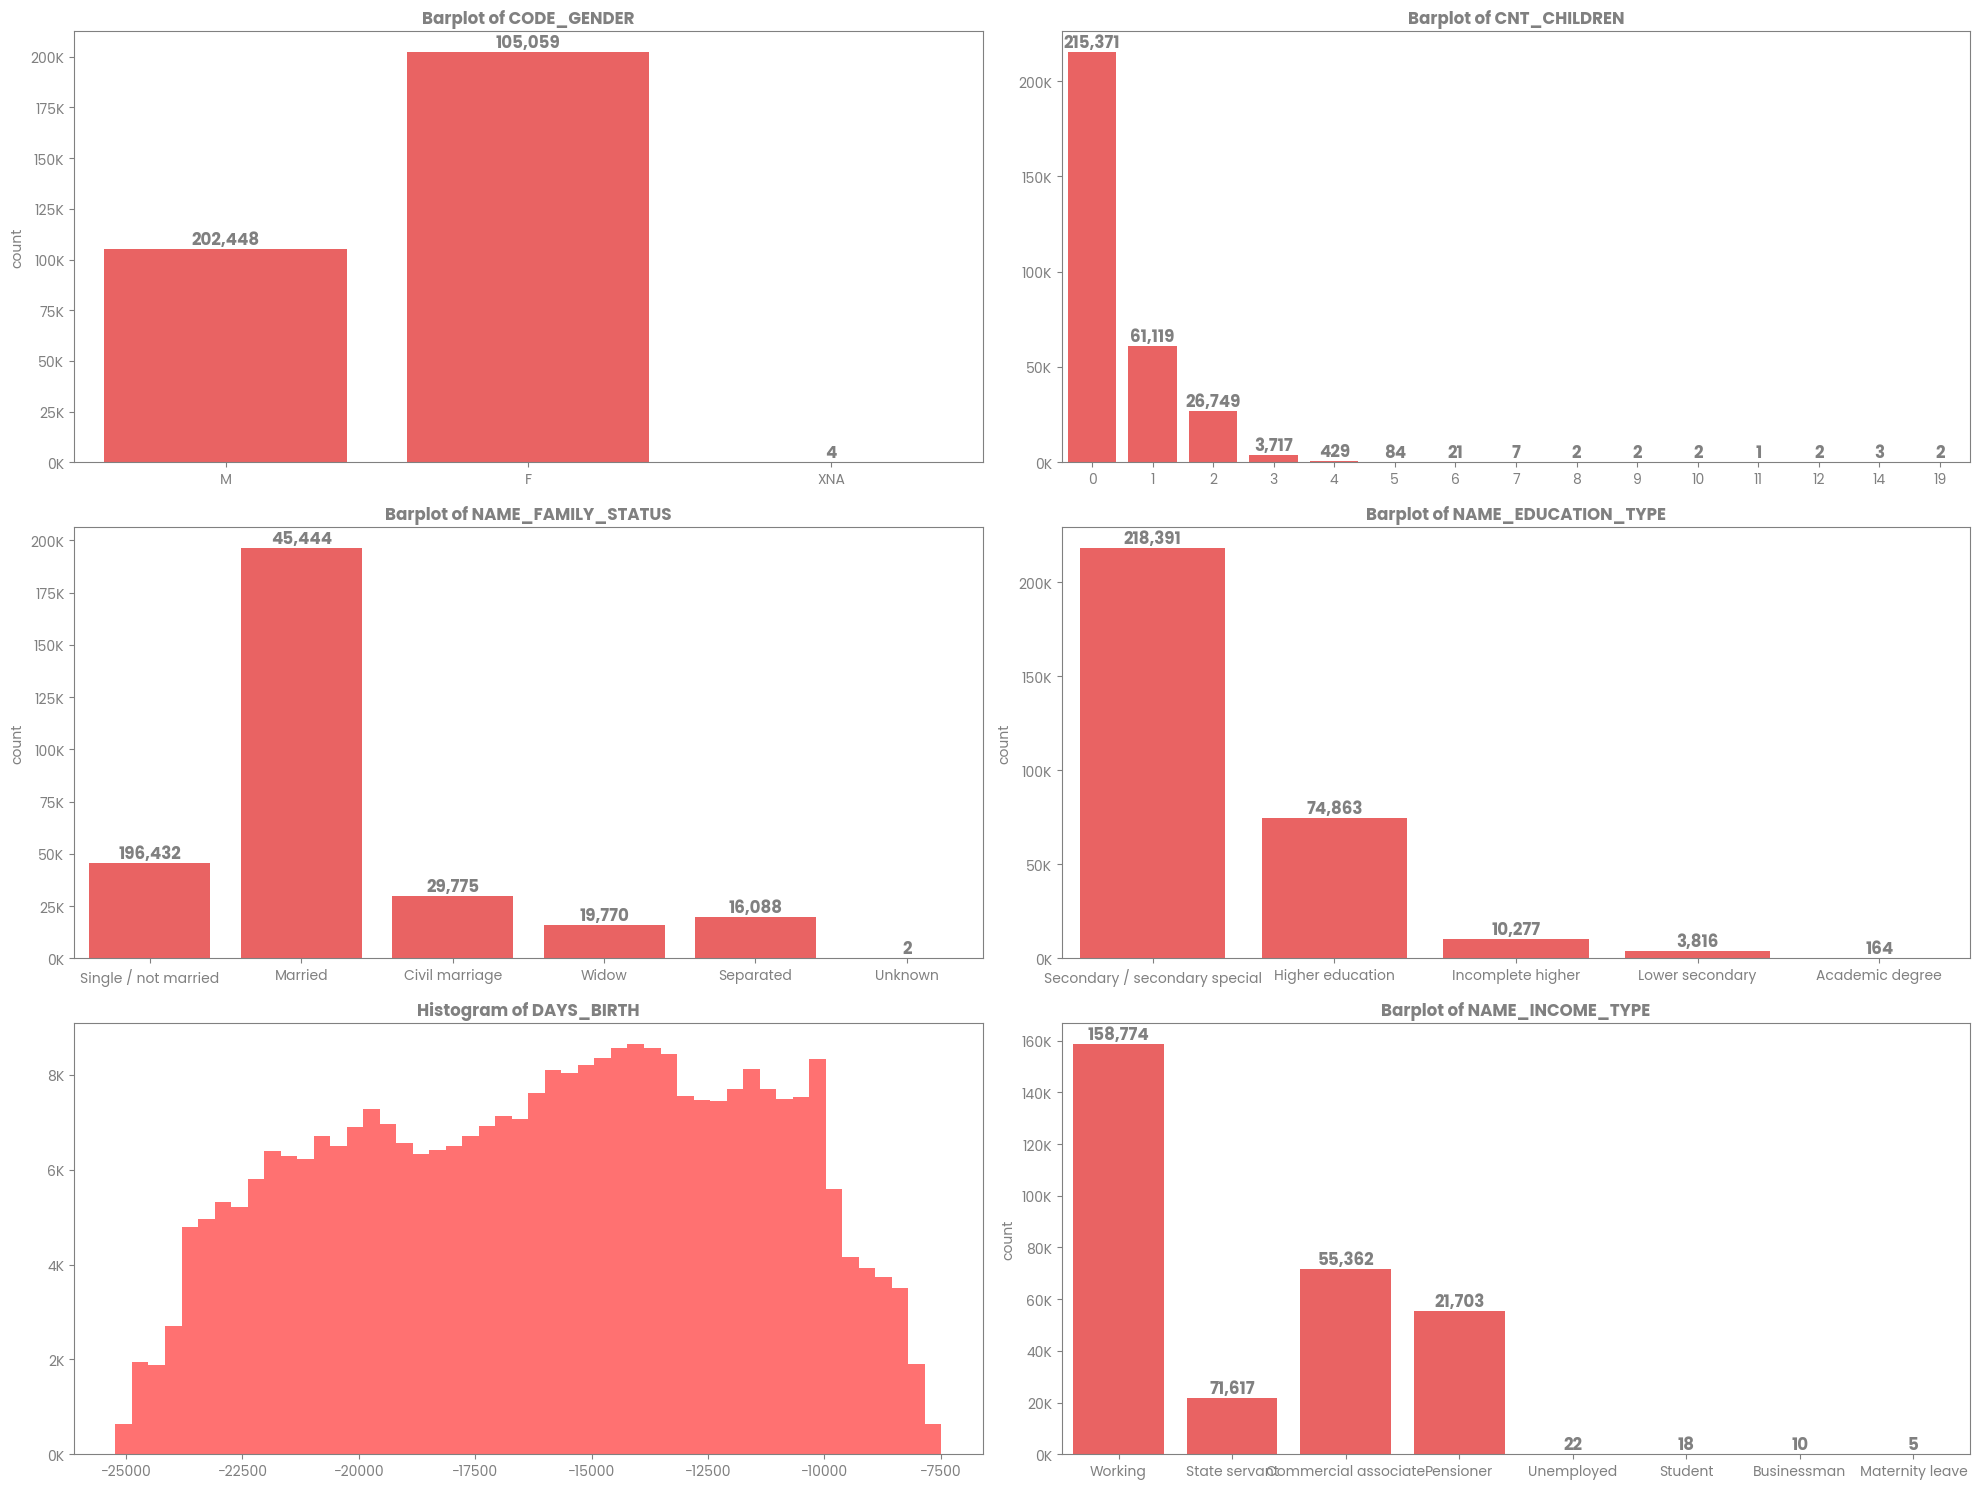

In [28]:
# Visualizing demographic characteristics
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
    ax = axes[i]

    if col == "CNT_CHILDREN":
        counts = final_train[col].value_counts().sort_index()
        sns.barplot(x=counts.index, y=counts.values, ax=ax)
        ax.set_title(f"Barplot of {col}")
        ax.set_xlabel("")
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))
        ax.bar_label(ax.containers[0], labels=[f"{format(v, ',')}" for v in counts.values],
                     color="#808080", fontsize=12, fontweight="bold")

    elif final_train[col].dtype in ['int64', 'float64']:
        ax.hist(final_train[col], bins=50, alpha=0.8, edgecolor=None)
        ax.set_title(f"Histogram of {col}")
        ax.set_xlabel("")
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

    else:
        counts = final_train[col].value_counts()
        sns.countplot(data=final_train, x=col, ax=ax)
        ax.set_title(f"Barplot of {col}")
        ax.set_xlabel("")
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))
        ax.bar_label(ax.containers[0], labels=[f"{format(v, ',')}" for v in counts.values],
                     color="#808080", fontsize=12, fontweight="bold")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

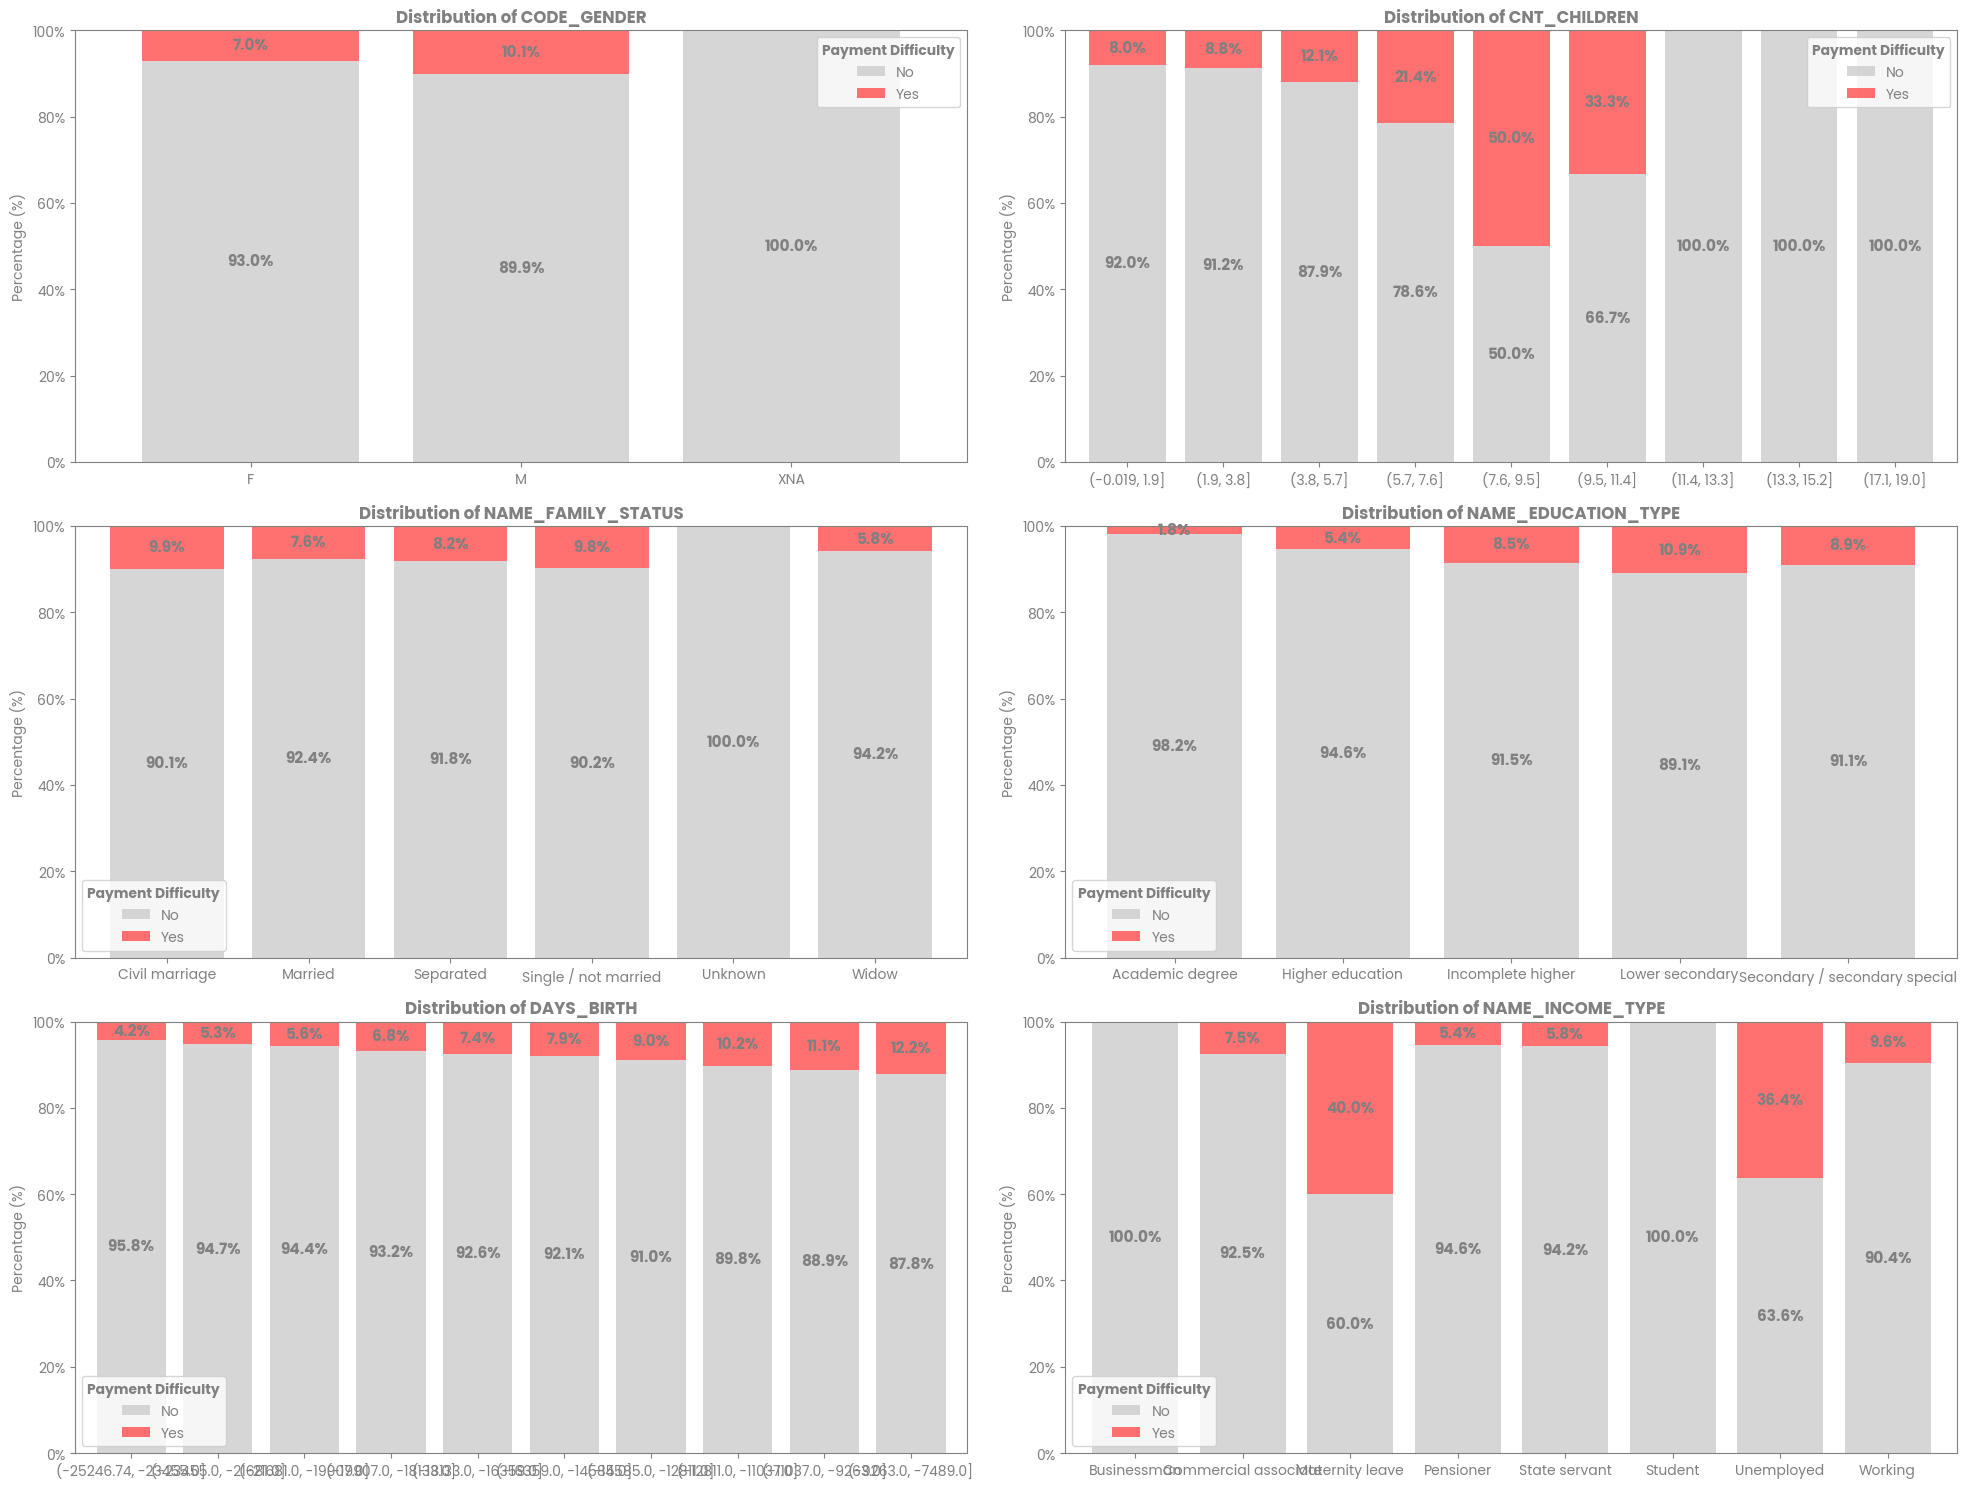

In [29]:
# Target distribution across demographic features
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
    ax = axes[i]

    if final_train[col].dtype in ['int64', 'float64']:
        data_col = final_train[col].dropna()
        bins = pd.cut(data_col, bins=10, duplicates='drop')
        cross_tab = pd.crosstab(bins, final_train.loc[data_col.index, 'TARGET'])
    else:
        cross_tab = pd.crosstab(final_train[col], final_train['TARGET'])
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f"{height:.1f}%", ha='center', va='center', fontsize=11, fontweight='bold', color='#808080')

    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 100)

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))

    legend = ax.legend(title='Payment Difficulty', labels=['No', 'Yes'])
    legend.get_title().set_color('#808080')
    legend.get_title().set_fontweight('bold')

    ax.tick_params(axis='x', rotation=0)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

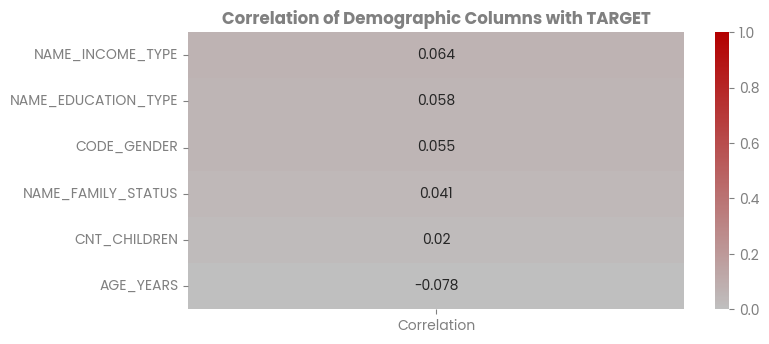

In [30]:
final_train['AGE_YEARS'] = (-final_train['DAYS_BIRTH'] / 365).astype(int)
num_cols = final_train[demographic_cols].select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = ['AGE_YEARS' if col=='DAYS_BIRTH' else col for col in num_cols]
cat_cols = final_train[demographic_cols].select_dtypes(include=['object','category']).columns.tolist()

# Korelasi numerik (Spearman)
num_corr = {}
for col in num_cols:
    corr, _ = spearmanr(final_train[col], final_train['TARGET'])
    num_corr[col] = corr

# Korelasi kategori (Cramér's V inline)
cat_corr = {}
for col in cat_cols:
    confusion_matrix = pd.crosstab(final_train[col], final_train['TARGET'])
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    cat_corr[col] = np.sqrt(chi2 / (n * (min(confusion_matrix.shape)-1)))

# Gabungkan semua korelasi
all_corr = {**num_corr, **cat_corr}
corr_df = pd.DataFrame.from_dict(all_corr, orient='index', columns=['Correlation'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, len(corr_df)*0.6))
sns.heatmap(corr_df, annot=True, cmap=cmap, vmin=0, vmax=1)
plt.title('Correlation of Demographic Columns with TARGET')
plt.show()

### **3.3.1. Gender Demographics Overview**

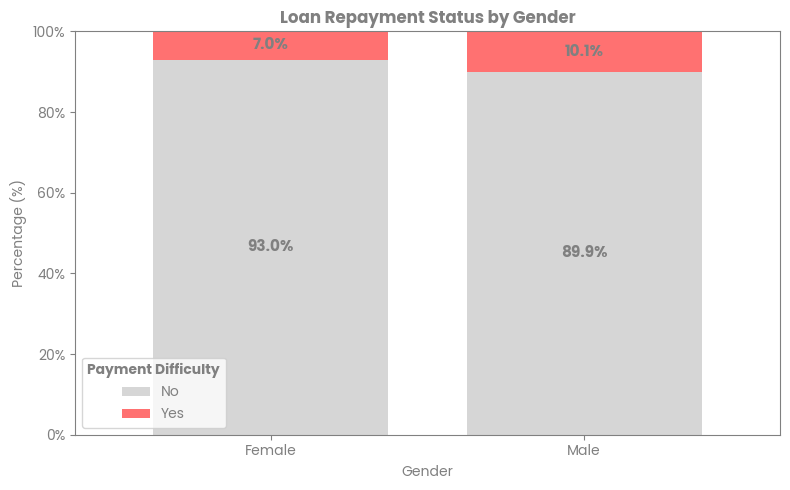

In [31]:
final_train['CODE_GENDER'] = final_train['CODE_GENDER'].replace({
    'F': 'Female',
    'M': 'Male',
    'XNA': 'Not Specified'
})

plot_data = final_train[final_train['CODE_GENDER'] != 'Not Specified']

cross_tab = pd.crosstab(plot_data['CODE_GENDER'], plot_data['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.75, color=['#CCCCCC', '#FF4D4D'])

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + height/2, f"{height:.1f}%",
                ha='center', va='center', fontsize=11,
                fontweight='bold', color='#808080'
            )

ax.set_title("Loan Repayment Status by Gender")
ax.set_xlabel("Gender")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
legend = ax.legend(title='Payment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### **3.3.2. Family Size Impact on Repayment Behavior**

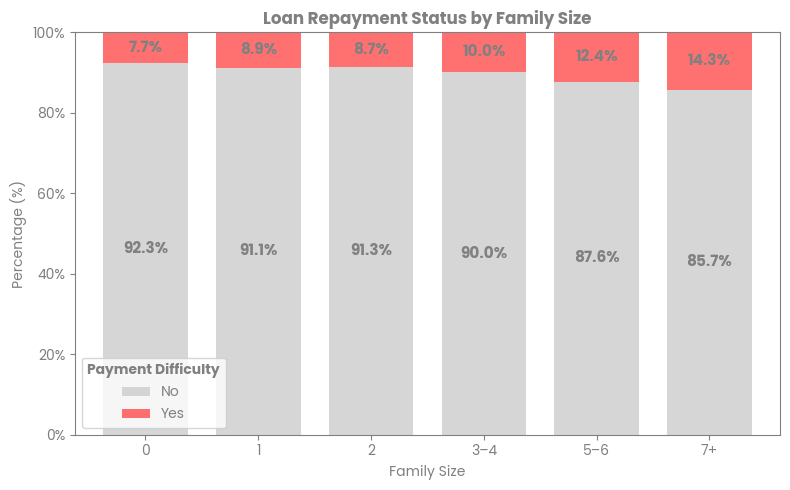

In [32]:
def group_children(x):
    if x == 0:
        return '0'
    elif x == 1:
        return '1'
    elif x == 2:
        return '2'
    elif x in [3, 4]:
        return '3–4'
    elif x in [5, 6]:
        return '5–6'
    else:
        return '7+'

final_train['CHILD_GROUP'] = final_train['CNT_CHILDREN'].apply(group_children)

cross_tab = pd.crosstab(final_train['CHILD_GROUP'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.75, color=['#CCCCCC', '#FF4D4D'])

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f"{height:.1f}%",
                    ha='center', va='center', fontsize=11, fontweight='bold', color='#808080')

ax.set_title("Loan Repayment Status by Family Size")
ax.set_xlabel("Family Size")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
legend = ax.legend(title='Payment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### **3.3. Marital Status Distribution Analysis**

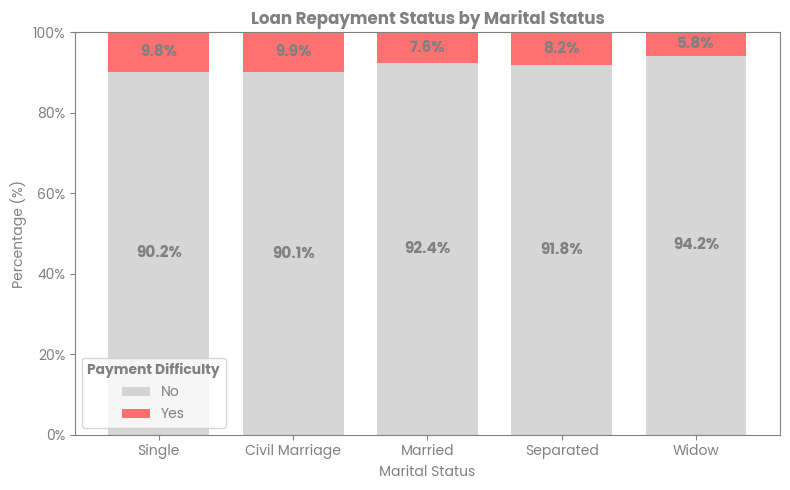

In [33]:
final_train['NAME_FAMILY_STATUS'] = final_train['NAME_FAMILY_STATUS'].replace({
    'Single / not married':'Single',
    'Civil marriage':'Civil Marriage'
})

status_order = ['Single', 'Civil Marriage', 'Married', 'Separated', 'Widow', 'Unknown']
cat_type = pd.CategoricalDtype(categories=status_order, ordered=True)
final_train['NAME_FAMILY_STATUS'] = final_train['NAME_FAMILY_STATUS'].astype(cat_type)

plot_data = final_train[final_train['NAME_FAMILY_STATUS'] != 'Unknown']

cross_tab = pd.crosstab(plot_data['NAME_FAMILY_STATUS'], plot_data['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.75, color=['#CCCCCC', '#FF4D4D'])

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + height/2,
                f"{height:.1f}%", ha='center',
                va='center', fontsize=11,
                fontweight='bold', color='#808080'
            )

ax.set_title("Loan Repayment Status by Marital Status")
ax.set_xlabel("Marital Status")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
legend = ax.legend(title='Payment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### **3.3.4. Academic Background Overview**

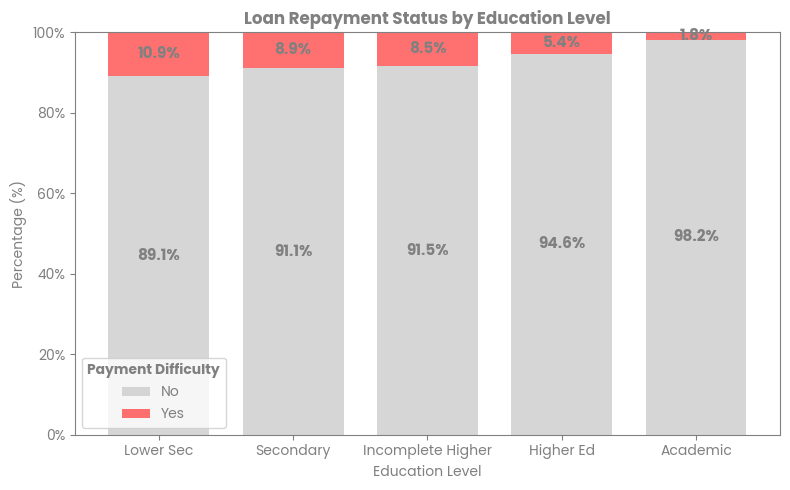

In [34]:
final_train['NAME_EDUCATION_TYPE'] = final_train['NAME_EDUCATION_TYPE'].replace({
    'Academic degree': 'Academic',
    'Higher education': 'Higher Ed',
    'Incomplete higher': 'Incomplete Higher',
    'Lower secondary': 'Lower Sec',
    'Secondary / secondary special': 'Secondary'
})

edu_order = ['Lower Sec', 'Secondary', 'Incomplete Higher', 'Higher Ed', 'Academic']
cat_type = pd.CategoricalDtype(categories=edu_order, ordered=True)
final_train['NAME_EDUCATION_TYPE'] = final_train['NAME_EDUCATION_TYPE'].astype(cat_type)

cross_tab = pd.crosstab(final_train['NAME_EDUCATION_TYPE'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.75, color=['#CCCCCC', '#FF4D4D'])

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + height/2,
                f"{height:.1f}%", ha='center',
                va='center', fontsize=11,
                fontweight='bold', color='#808080'
            )

ax.set_title("Loan Repayment Status by Education Level")
ax.set_xlabel("Education Level")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))

legend = ax.legend(title='Payment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### **3.3.5. Generational Payment Patterns**

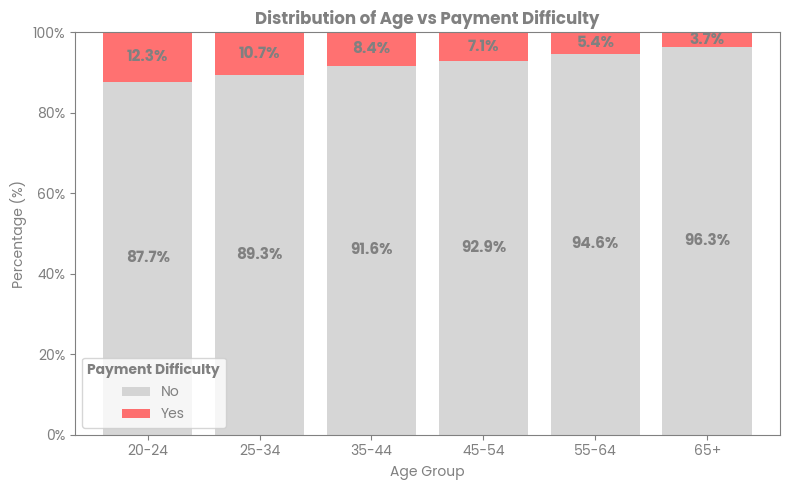

In [35]:
# Konversi DAYS_BIRTH ke AGE_YEARS
final_train['AGE_YEARS'] = (-final_train['DAYS_BIRTH'] / 365).astype(int)

# Custom bin sesuai konteks credit scoring
bins = [20, 25, 35, 45, 55, 65, 75]
labels = ['20-24', '25-34', '35-44', '45-54', '55-64', '65+']
final_train['AGE_BIN'] = pd.cut(final_train['AGE_YEARS'], bins=bins, labels=labels, right=False)

# Crosstab AGE_BIN vs TARGET
cross_tab = pd.crosstab(final_train['AGE_BIN'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Plot stacked bar
fig, ax = plt.subplots(figsize=(8, 5))
bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

# Tambahkan persentase di atas bar
for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f"{height:.1f}%",
                    ha='center', va='center', fontsize=11, fontweight='bold', color='#808080')

ax.set_title("Distribution of Age vs Payment Difficulty")
ax.set_xlabel("Age Group")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))

legend = ax.legend(title='Payment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### **3.3.6. Employment Category Paradox**

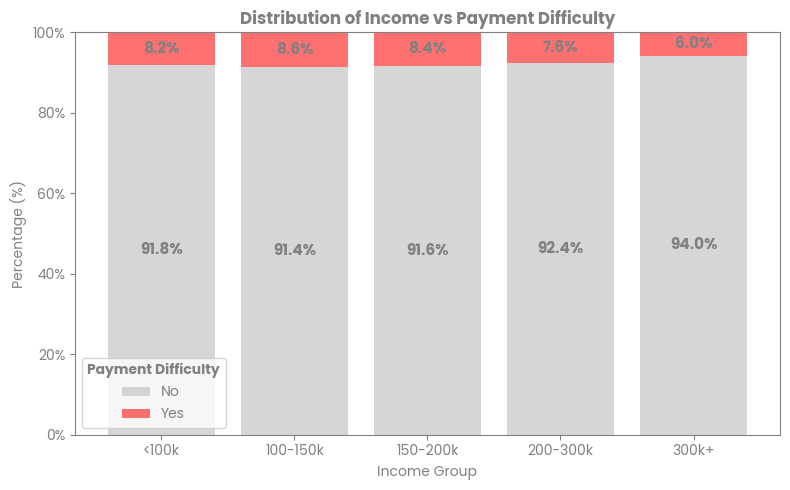

In [36]:
bins = [0, 100000, 150000, 200000, 300000, final_train['AMT_INCOME_TOTAL'].max()]
labels = ['<100k', '100-150k', '150-200k', '200-300k', '300k+']
final_train['INCOME_BIN'] = pd.cut(final_train['AMT_INCOME_TOTAL'], bins=bins, labels=labels)

cross_tab = pd.crosstab(final_train['INCOME_BIN'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f"{height:.1f}%",
                    ha='center', va='center', fontsize=11, fontweight='bold', color='#808080')

ax.set_title("Distribution of Income vs Payment Difficulty")
ax.set_xlabel("Income Group")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))

legend = ax.legend(title='Payment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### **3.3.7. Occupation Type Distribution Analysis**

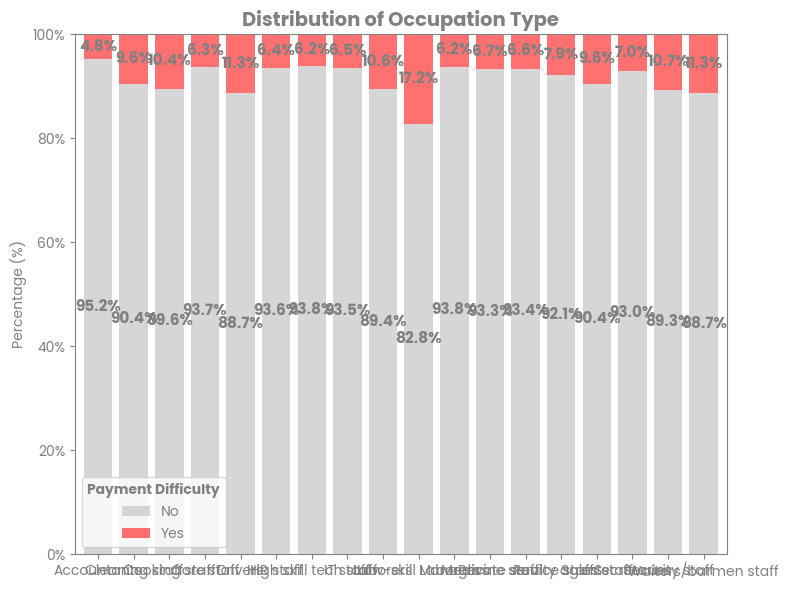

In [37]:
cross_tab = pd.crosstab(final_train['OCCUPATION_TYPE'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8, 6))
bars = cross_tab_pct.plot(kind="bar", stacked=True, ax=ax, alpha=0.8, width=0.8, color=["#CCCCCC", "#FF4D4D"])

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + height/2, f"{height:.1f}%",
                ha="center", va="center",
                fontsize=11, fontweight="bold", color="#808080"
            )

ax.set_title("Distribution of Occupation Type", fontsize=14, fontweight="bold")
ax.set_xlabel("")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{int(x)}%"))

legend = ax.legend(title="Payment Difficulty", labels=["No", "Yes"])
legend.get_title().set_color("#808080")
legend.get_title().set_fontweight("bold")

ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()

## **3.4. Customer Financial Analysis**

In [38]:
# Financial columns
financial_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED']
financial_cols = [col for col in financial_cols if col in final_train.columns]

display(final_train[financial_cols + ['TARGET']].groupby('TARGET').describe())

AMT_INCOME_TOTAL                                                   \
                  count           mean            std      min       25%   
TARGET                                                                     
0              282686.0  169077.722266  110476.268524  25650.0  112500.0   
1               24825.0  165611.760906  746676.959440  25650.0  112500.0   

                                        AMT_CREDIT                 \
             50%       75%          max      count           mean   
TARGET                                                              
0       148500.0  202500.0   18000090.0   282686.0  602648.282002   
1       135000.0  202500.0  117000000.0    24825.0  557778.527674   

                                                                         \
                  std      min       25%       50%       75%        max   
TARGET                                                                    
0       406845.907710  45000.0  270000.0  517788.0  810000.0  4050000.0   
1       346433.235646  45000.0  284400.0  497520.0  733315.5  4027680.0   

       AMT_ANNUITY                                                        \
             count          mean           std     min      25%      50%   
TARGET                                                                     
0         282674.0  27163.623349  14658.307178  1615.5  16456.5  24876.0   
1          24825.0  26481.744290  12450.676999  2722.5  17361.0  25263.0   

                          AMT_GOODS_PRICE                                \
            75%       max           count           mean            std   
TARGET                                                                    
0       34749.0  258025.5        282429.0  542736.795003  373785.493534   
1       32976.0  149211.0         24804.0  488972.412554  311636.495297   

                                                         DAYS_EMPLOYED  \
            min       25%       50%       75%        max         count   
TARGET                                                                   
0       40500.0  238500.0  450000.0  688500.0  4050000.0      282686.0   
1       45000.0  238500.0  450000.0  675000.0  3600000.0       24825.0   

                                                                               
                mean            std      min     25%     50%    75%       max  
TARGET                                                                         
0       65696.146123  142877.810161 -17912.0 -2813.0 -1235.0 -278.0  365243.0  
1       42394.675448  119484.634253 -16069.0 -2156.0 -1034.0 -379.0  365243.0

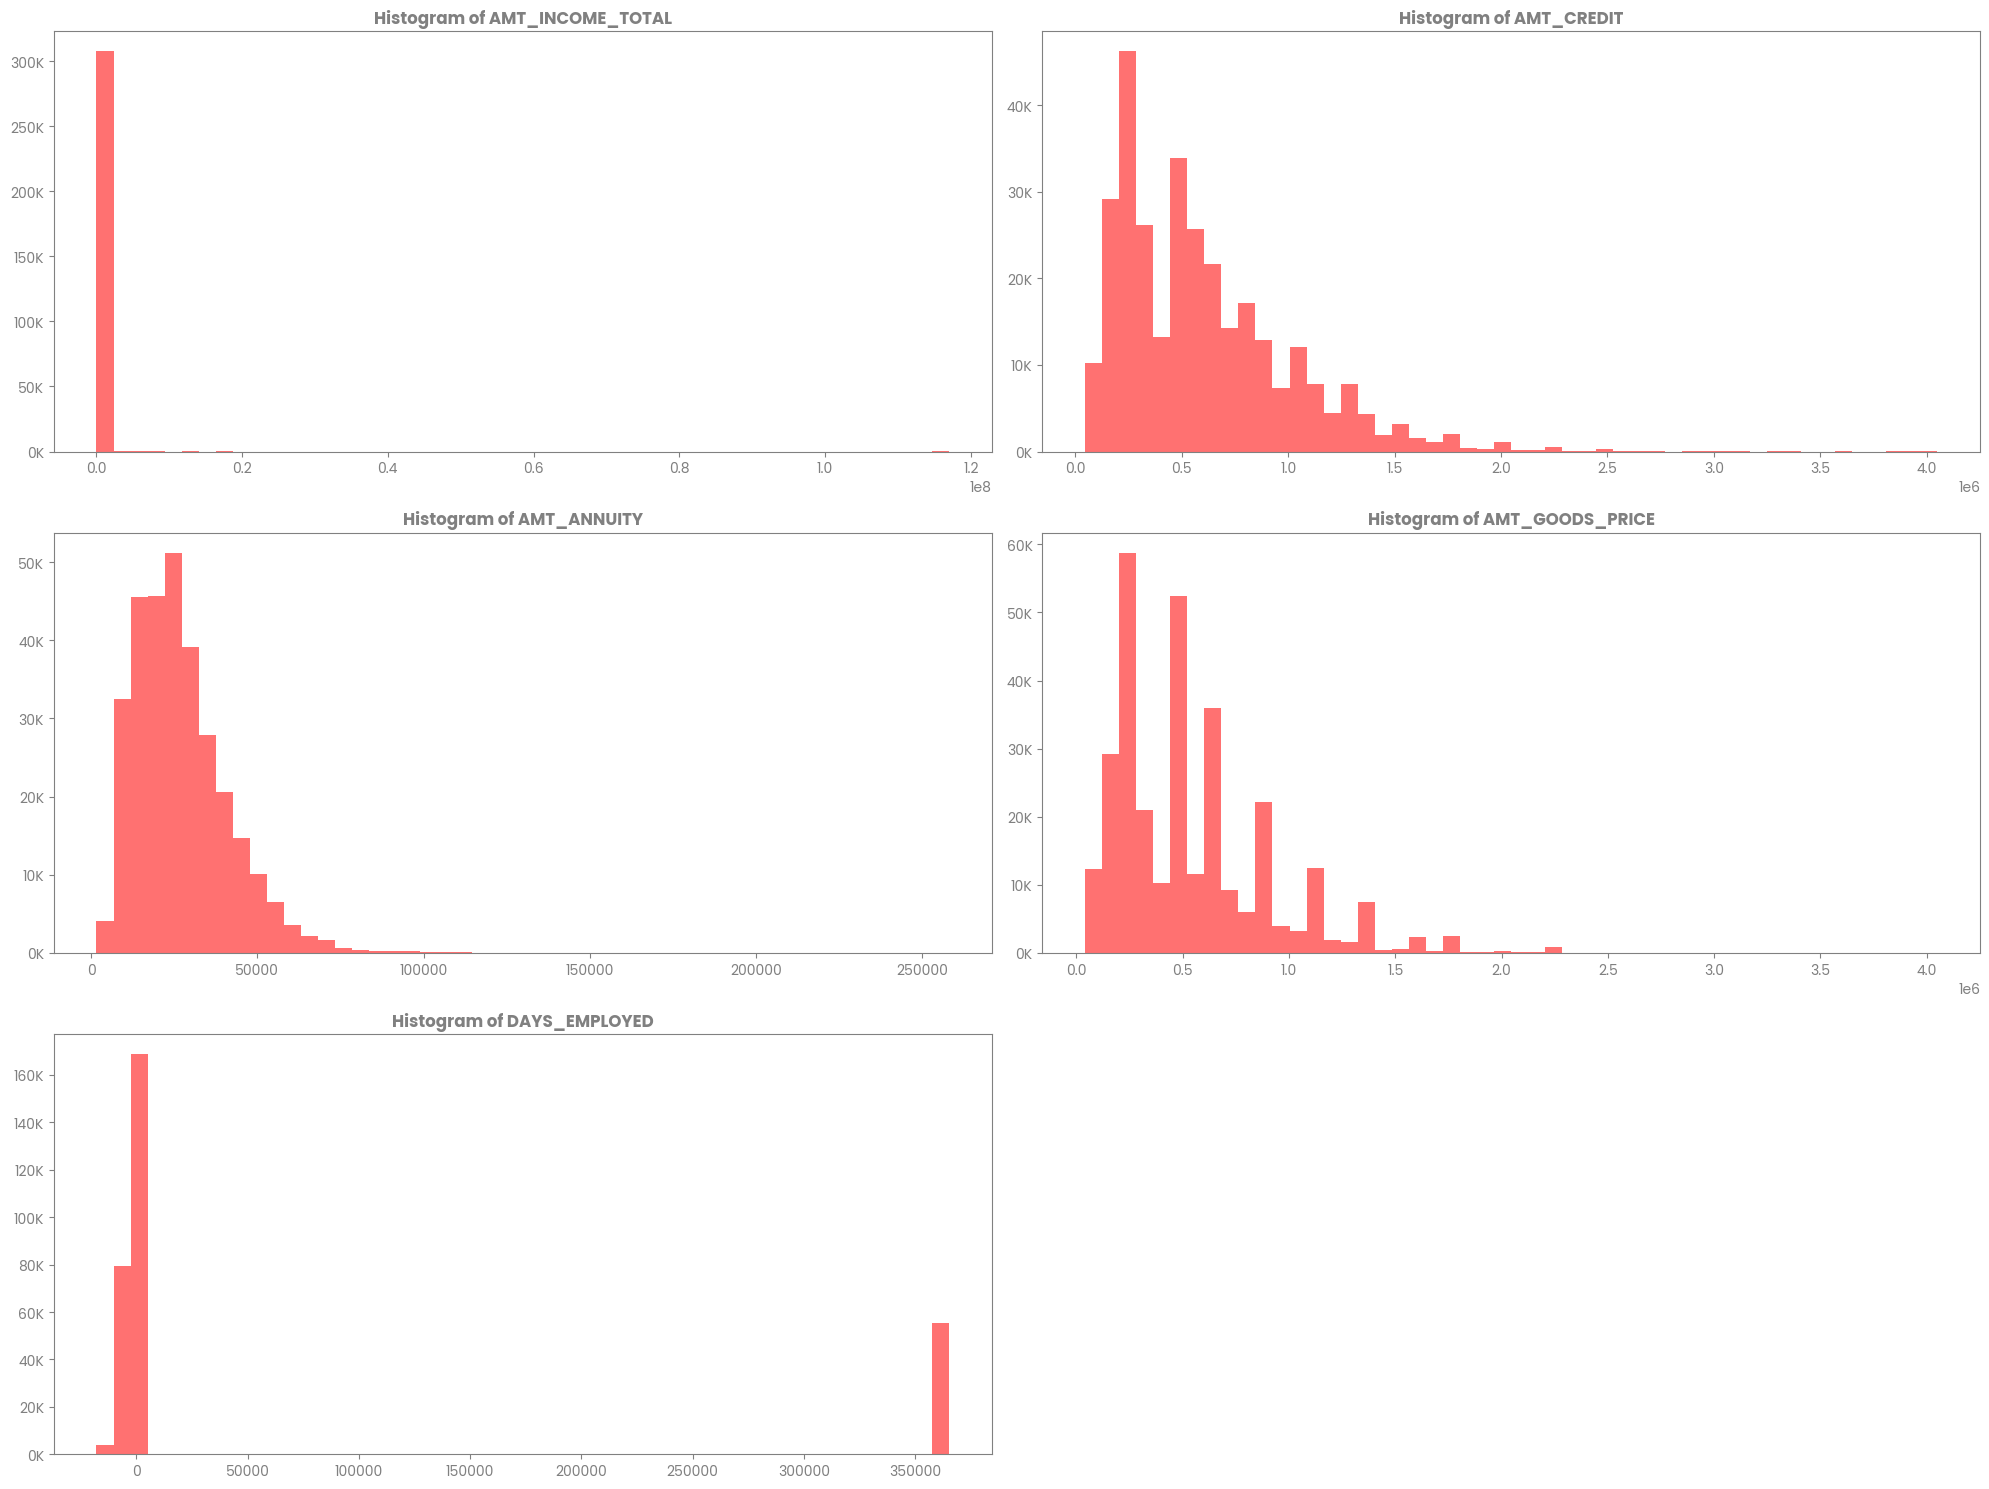

In [39]:
# Visualizing financial characteristics
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(financial_cols):
    ax = axes[i]
    ax.hist(final_train[col], bins=50, alpha=0.8, edgecolor=None)

    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel("")
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

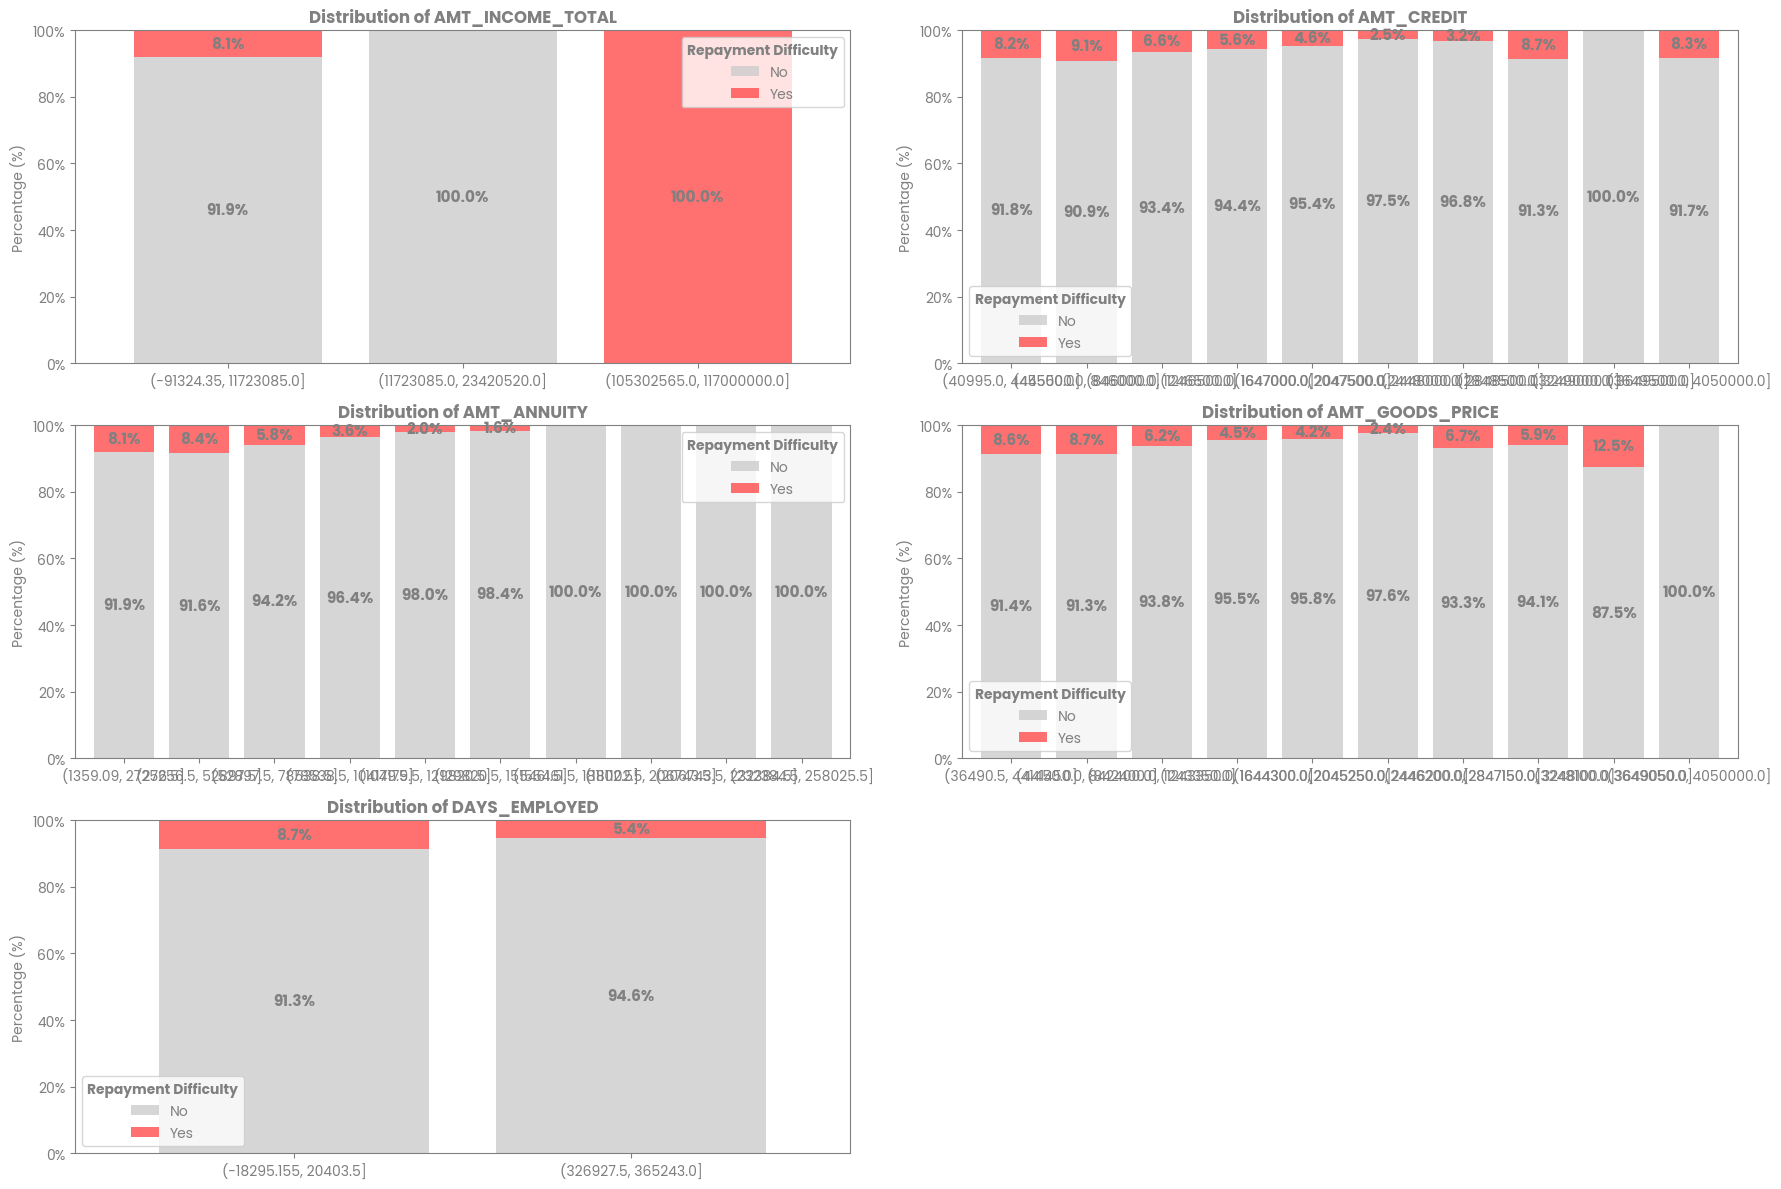

In [40]:
# Target distribution across financial features
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(financial_cols):
    ax = axes[i]

    data_col = final_train[col].dropna()
    bins = pd.cut(data_col, bins=10, duplicates='drop')
    cross_tab = pd.crosstab(bins, final_train.loc[data_col.index, 'TARGET'])
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f"{height:.1f}%", ha='center', va='center', fontsize=11, fontweight='bold', color='#808080')

    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 100)

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))

    legend = ax.legend(title='Repayment Difficulty', labels=['No', 'Yes'])
    legend.get_title().set_color('#808080')
    legend.get_title().set_fontweight('bold')

    ax.tick_params(axis='x', rotation=0)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

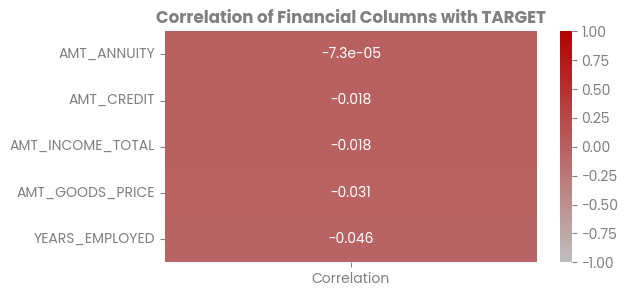

In [41]:
fin_df = final_train[financial_cols + ['TARGET']].copy()

if 'DAYS_EMPLOYED' in fin_df.columns:
    fin_df['YEARS_EMPLOYED'] = (fin_df['DAYS_EMPLOYED'] / 365).clip(lower=0)
    financial_cols = [col if col != 'DAYS_EMPLOYED' else 'YEARS_EMPLOYED' for col in financial_cols]

fin_df = fin_df.fillna(fin_df.median())

fin_corr = {}
for col in financial_cols:
    corr, _ = spearmanr(fin_df[col], fin_df['TARGET'])
    fin_corr[col] = corr

fin_corr_df = pd.DataFrame.from_dict(fin_corr, orient='index', columns=['Correlation'])
fin_corr_df = fin_corr_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(6, len(fin_corr_df)*0.6))
sns.heatmap(fin_corr_df, annot=True, cmap=cmap, vmin=-1, vmax=1)
plt.title('Correlation of Financial Columns with TARGET')
plt.show()

### **3.4.1. Customer Income Distribution**

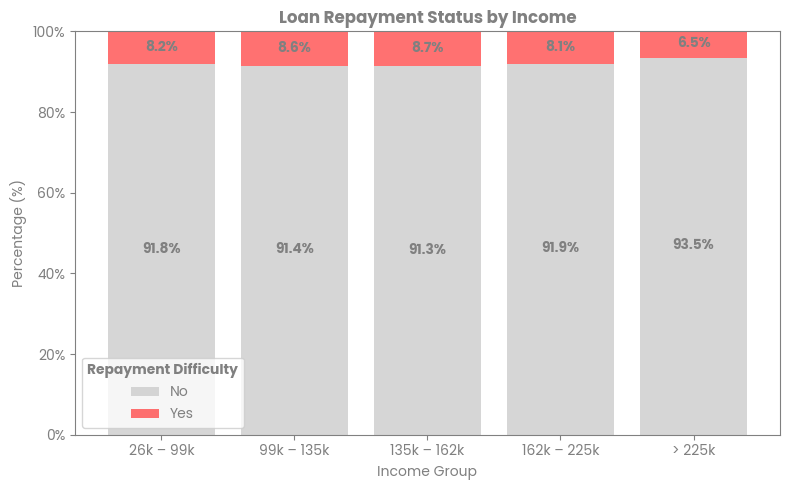

In [42]:
income_bins = pd.qcut(final_train['AMT_INCOME_TOTAL'], q=5, duplicates='drop')

bin_edges = income_bins.cat.categories
labels = []
for interval in bin_edges:
    left = int(interval.left)
    right = int(interval.right)
    if left == bin_edges[0].left:
        labels.append(f"≤ {right/1000:.0f}k")
    elif right == bin_edges[-1].right:
        labels.append(f"> {left/1000:.0f}k")
    else:
        labels.append(f"{left/1000:.0f}k – {right/1000:.0f}k")

final_train['AMT_INCOME_BIN_Q'] = pd.qcut(final_train['AMT_INCOME_TOTAL'], q=5, duplicates='drop',labels=labels)

fig, ax = plt.subplots(figsize=(8, 5))

cross_tab = pd.crosstab(final_train['AMT_INCOME_BIN_Q'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_y() + height/2,
                    f"{height:.1f}%", ha='center', va='center',
                    fontsize=10, fontweight='bold', color='#808080')

ax.set_title("Loan Repayment Status by Income")
ax.set_xlabel("Income Group")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
ax.tick_params(axis='x', rotation=0)

legend = ax.legend(title='Repayment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

### **3.4.2. Employment Pattern Analysis**

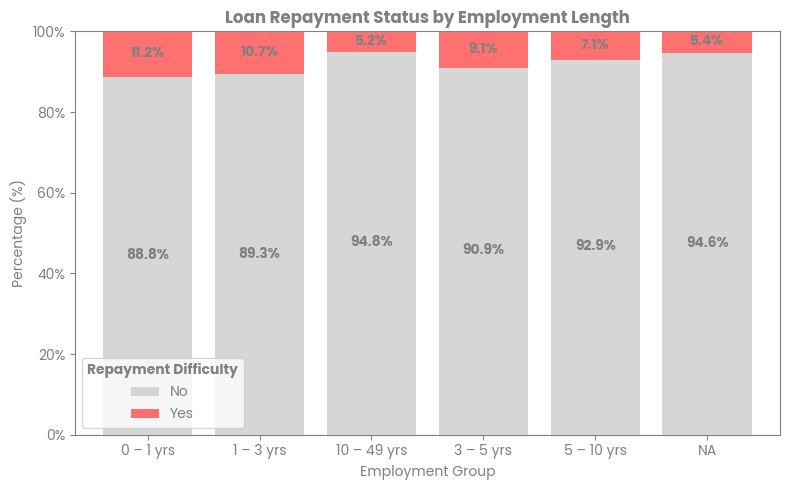

In [43]:
final_train['DAYS_EMPLOYED_BIN'] = final_train['DAYS_EMPLOYED']
final_train['DAYS_EMPLOYED_BIN'] = final_train['DAYS_EMPLOYED_BIN'].replace(365243, np.nan)
final_train['YEARS_EMPLOYED'] = -(final_train['DAYS_EMPLOYED_BIN'] / 365).round(1)

emp_bins = pd.qcut(final_train['YEARS_EMPLOYED'].dropna(), q=5, duplicates='drop')

bin_edges = emp_bins.cat.categories
labels = []
for interval in bin_edges:
    left = int(interval.left)
    right = int(interval.right)
    if left == bin_edges[0].left:
        labels.append(f"≤ {right} yrs")
    elif right == bin_edges[-1].right:
        labels.append(f"> {left} yrs")
    else:
        labels.append(f"{left} – {right} yrs")

final_train['EMPLOYED_BIN_Q'] = pd.qcut(
    final_train['YEARS_EMPLOYED'].dropna(),
    q=5,
    duplicates='drop',
    labels=labels
)

final_train['EMPLOYED_BIN_Q'] = final_train['EMPLOYED_BIN_Q'].astype(str)
final_train.loc[final_train['DAYS_EMPLOYED'] == 365243, 'EMPLOYED_BIN_Q'] = 'NA'

fig, ax = plt.subplots(figsize=(8, 5))

cross_tab = pd.crosstab(final_train['EMPLOYED_BIN_Q'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_y() + height/2,
                    f"{height:.1f}%", ha='center', va='center',
                    fontsize=10, fontweight='bold', color='#808080')

ax.set_title("Loan Repayment Status by Employment Length")
ax.set_xlabel("Employment Group")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
ax.tick_params(axis='x', rotation=0)

legend = ax.legend(title='Repayment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

### **3.4.3. Credit Amount Distribution**

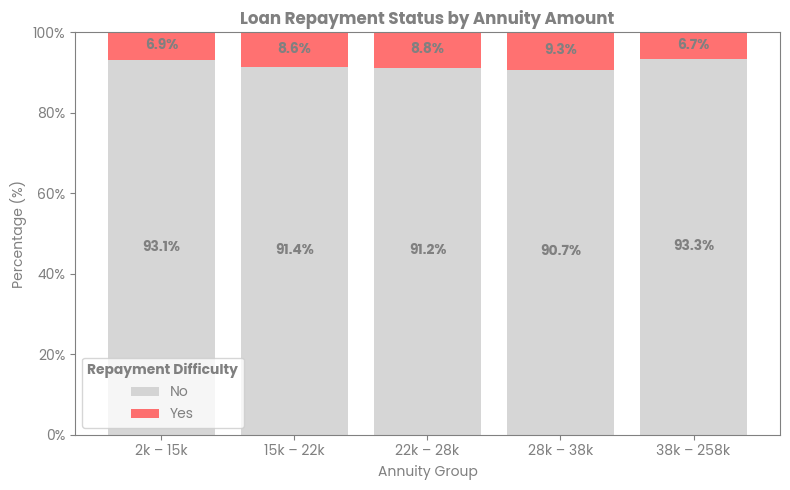

In [44]:
annuity_bins = pd.qcut(final_train['AMT_ANNUITY'], q=5, duplicates='drop')

bin_edges = annuity_bins.cat.categories
labels = []
for interval in bin_edges:
    left = int(interval.left)
    right = int(interval.right)
    if left == bin_edges[0].left:
        labels.append(f"≤ {right/1000:.0f}k")
    elif right == bin_edges[-1].right:
        labels.append(f"> {left/1000:.0f}k")
    else:
        labels.append(f"{left/1000:.0f}k – {right/1000:.0f}k")

final_train['AMT_ANNUITY_BIN_Q'] = pd.qcut(
    final_train['AMT_ANNUITY'],
    q=5,
    duplicates='drop',
    labels=labels
)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

cross_tab = pd.crosstab(final_train['AMT_ANNUITY_BIN_Q'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

bars = cross_tab_pct.plot(
    kind='bar', stacked=True, ax=ax,
    alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D']
)

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_y() + height/2,
                    f"{height:.1f}%", ha='center', va='center',
                    fontsize=10, fontweight='bold', color='#808080')

ax.set_title("Loan Repayment Status by Annuity Amount")
ax.set_xlabel("Annuity Group")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
ax.tick_params(axis='x', rotation=0)

legend = ax.legend(title='Repayment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

## **3.5. Customer Asset Analysis**

In [45]:
# Property columns
property_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE','OWN_CAR_AGE']
property_cols = [col for col in property_cols if col in final_train.columns]

num_cols = final_train[property_cols].select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = final_train[property_cols].select_dtypes(include=['object','category']).columns.tolist()

display(final_train[num_cols + ['TARGET']].groupby('TARGET').describe())
display(final_train[cat_cols + ['TARGET']].groupby('TARGET').describe())

OWN_CAR_AGE                                                  
             count       mean        std  min  25%   50%   75%   max
TARGET                                                              
0          97006.0  11.935540  11.891359  0.0  5.0   9.0  15.0  91.0
1           7576.0  13.668691  12.499074  0.0  6.0  11.0  17.0  91.0

FLAG_OWN_CAR                    FLAG_OWN_REALTY                     \
              count unique top    freq           count unique top    freq   
TARGET                                                                      
0            282686      2   N  185675          282686      2   Y  196329   
1             24825      2   N   17249           24825      2   Y   16983   

       NAME_HOUSING_TYPE                                    
                   count unique                top    freq  
TARGET                                                      
0                 282686      6  House / apartment  251596  
1                  24825      6  House / apartment   21272

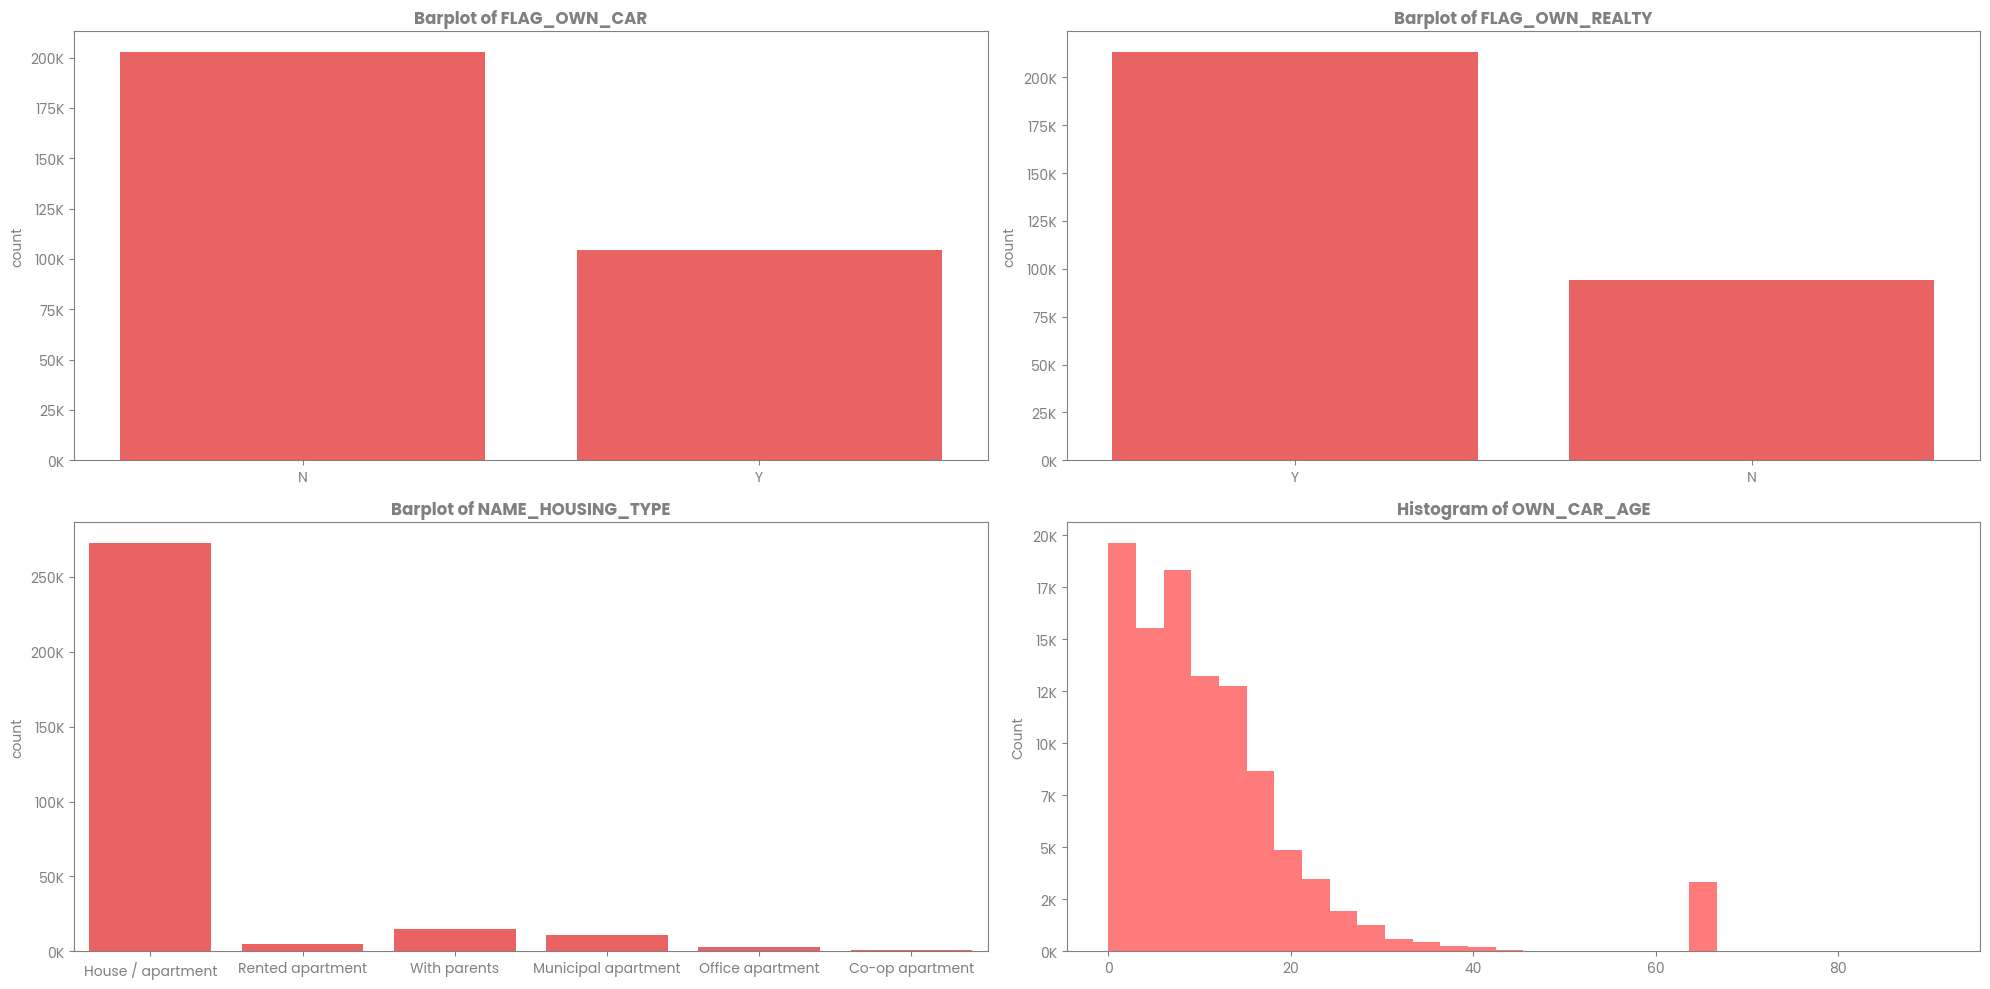

In [46]:
# Visualizing property characteristics
property_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE','OWN_CAR_AGE']

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(property_cols):
    ax = axes[i]
    if final_train[col].dtype in ['int64', 'float64']:
        sns.histplot(data=final_train, x=col, kde=False, bins=30, ax=ax, edgecolor=None)
        ax.set_title(f"Histogram of {col}")
        ax.set_xlabel("")
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))
    else:
        sns.countplot(data=final_train, x=col, ax=ax)
        ax.set_title(f"Barplot of {col}")
        ax.set_xlabel("")
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

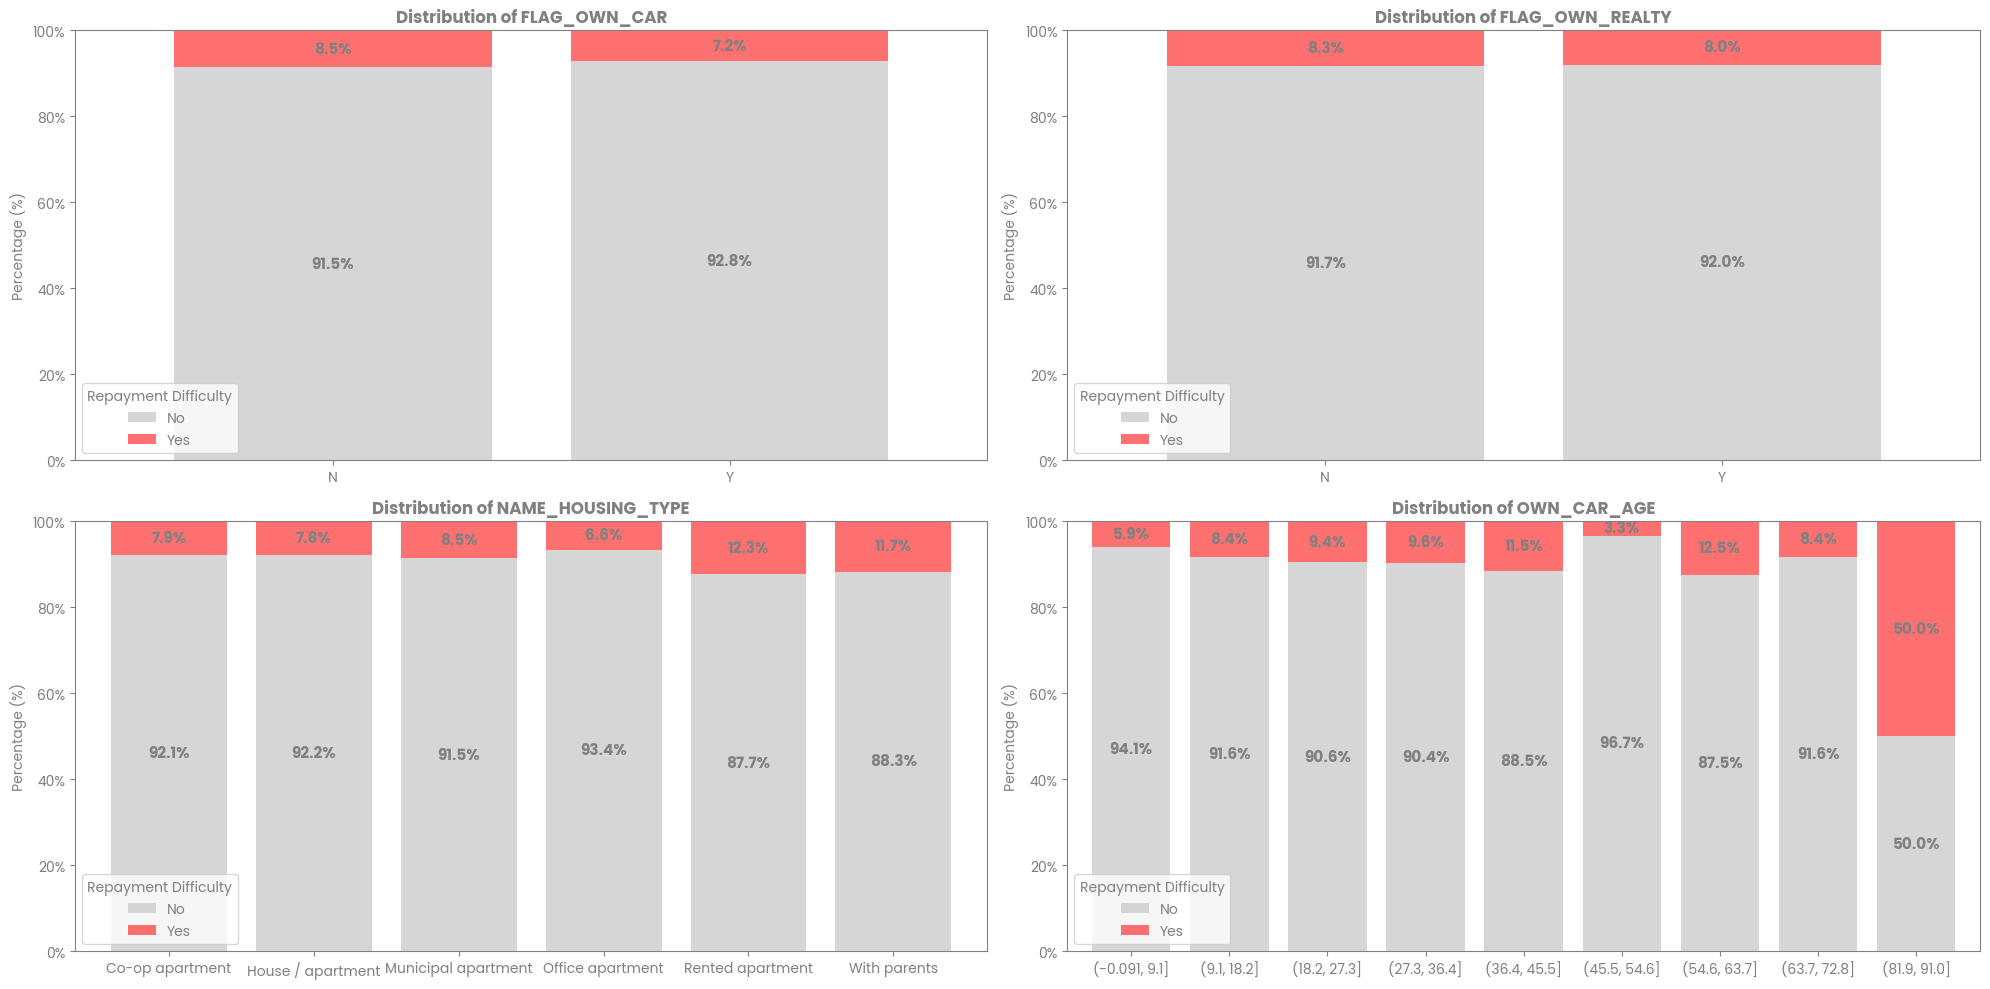

In [47]:
# Target distribution across property features
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(property_cols):
    ax = axes[i]

    if final_train[col].dtype in ['int64', 'float64']:
        data_col = final_train[col].dropna()
        bins = pd.cut(data_col, bins=10, duplicates='drop')
        cross_tab = pd.crosstab(bins, final_train.loc[data_col.index, 'TARGET'])
    else:
        cross_tab = pd.crosstab(final_train[col], final_train['TARGET'])
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f"{height:.1f}%", ha='center', va='center', fontsize=11, fontweight='bold', color='#808080')

    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 100)

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))

    legend = ax.legend(title='Repayment Difficulty', labels=['No', 'Yes'])
    legend.get_title().set_color('#808080')

    ax.tick_params(axis='x', rotation=0)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

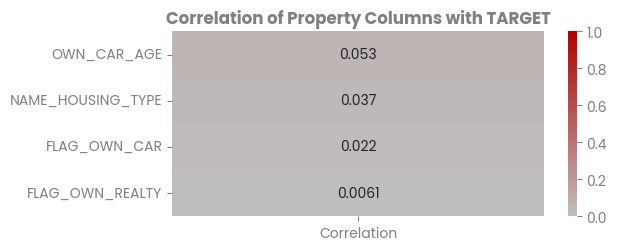

In [48]:
num_cols = final_train[property_cols].select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = final_train[property_cols].select_dtypes(include=['object','category']).columns.tolist()

num_corr = {}
for col in num_cols:
    corr, _ = spearmanr(final_train[[col, 'TARGET']].dropna()[col],
                        final_train[[col, 'TARGET']].dropna()['TARGET'])
    num_corr[col] = corr

cat_corr = {}
for col in cat_cols:
    confusion_matrix = pd.crosstab(final_train[col], final_train['TARGET'])
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    cat_corr[col] = np.sqrt(chi2 / (n * (min(confusion_matrix.shape)-1)))

all_corr = {**num_corr, **cat_corr}
corr_df = pd.DataFrame.from_dict(all_corr, orient='index', columns=['Correlation'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(6, len(corr_df)*0.6))
sns.heatmap(corr_df, annot=True, cmap=cmap, vmin=0, vmax=1)
plt.title('Correlation of Property Columns with TARGET')
plt.show()

### **3.5.1. Vehicle Age Impact on Repayment Performance**

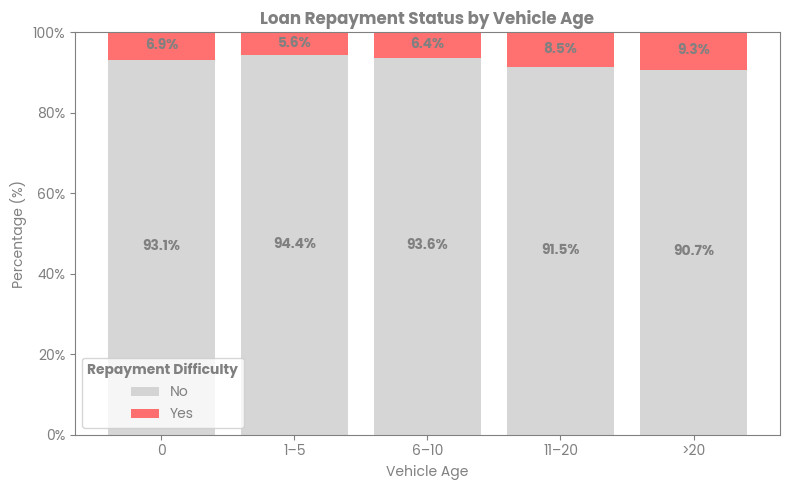

In [49]:
bins = [-1, 0, 5, 10, 20, 100]  # max = 91
labels = ["0", "1–5", "6–10", "11–20", ">20"]

final_train['OWN_CAR_AGE_BIN'] = pd.cut(final_train['OWN_CAR_AGE'], bins=bins, labels=labels)

# Crosstab
fig, ax = plt.subplots(figsize=(8, 5))

cross_tab = pd.crosstab(final_train['OWN_CAR_AGE_BIN'], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

bars = cross_tab_pct.plot(
    kind='bar', stacked=True, ax=ax,
    alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D']
)

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_y() + height/2,
                    f"{height:.1f}%", ha='center', va='center',
                    fontsize=10, fontweight='bold', color='#808080')

ax.set_title("Loan Repayment Status by Vehicle Age")
ax.set_xlabel("Vehicle Age")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
ax.tick_params(axis='x', rotation=0)

legend = ax.legend(title='Repayment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

### **3.5.2. Housing Type Risk Assessment**

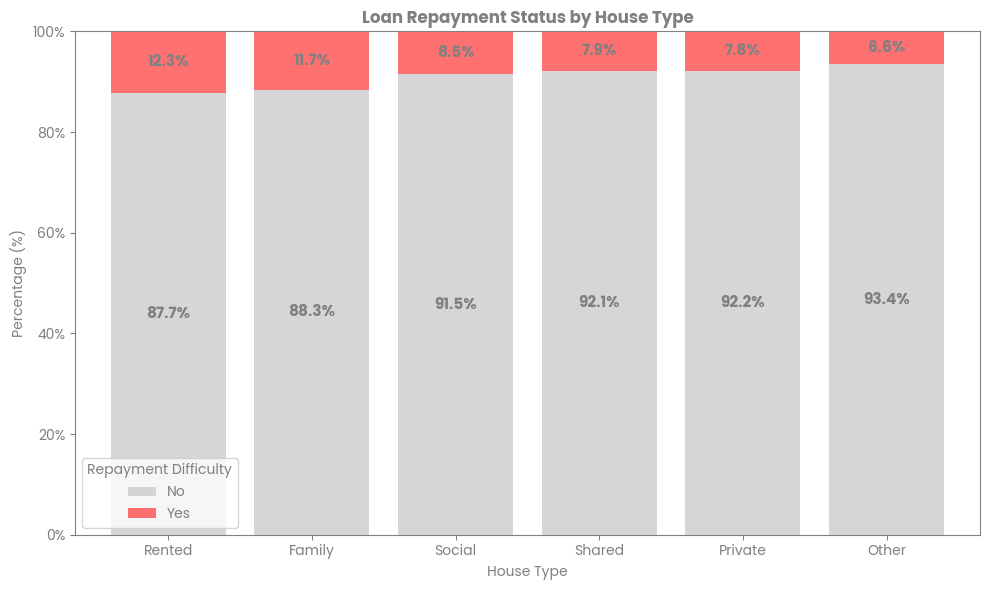

In [50]:
housing_map = {
    'House / apartment': 'Private',
    'Rented apartment': 'Rented',
    'With parents': 'Family',
    'Municipal apartment': 'Social',
    'Office apartment': 'Other',
    'Co-op apartment': 'Shared'
}

final_train['HOUSING_GROUPED'] = final_train['NAME_HOUSING_TYPE'].map(housing_map)

cross_tab = pd.crosstab(final_train["HOUSING_GROUPED"], final_train['TARGET'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

sorted_index = cross_tab_pct[1].sort_values(ascending=False).index
cross_tab_pct = cross_tab_pct.loc[sorted_index]

fig, ax = plt.subplots(figsize=(10, 6))
bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

# Tambahkan label persentase di dalam bar
for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f"{height:.1f}%",
                    ha='center', va='center', fontsize=11, fontweight='bold', color='#808080')

ax.set_title("Loan Repayment Status by House Type")
ax.set_xlabel("House Type")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
ax.tick_params(axis='x', rotation=0)

legend = ax.legend(title='Repayment Difficulty', labels=['No', 'Yes'])
legend.get_title().set_color('#808080')

plt.tight_layout()
plt.show()

## **3.6. External Sources Analysis**

In [51]:
# External sources columns
external_cols = [col for col in final_train.columns if 'EXT_SOURCE' in col]
display(final_train[external_cols + ['TARGET']].groupby('TARGET').describe())

EXT_SOURCE_1                                                    \
              count      mean       std       min       25%       50%   
TARGET                                                                  
0          124079.0  0.511461  0.208804  0.014568  0.345430  0.517452   
1           10054.0  0.386968  0.204729  0.014691  0.221847  0.361675   

                           EXT_SOURCE_2                                    \
             75%       max        count      mean       std           min   
TARGET                                                                      
0       0.682839  0.962693     282078.0  0.523479  0.186277  8.173617e-08   
1       0.537508  0.929394      24773.0  0.410935  0.213107  5.002109e-06   

                                              EXT_SOURCE_3            \
             25%       50%       75%      max        count      mean   
TARGET                                                                 
0       0.409787  0.573905  0.667705  0.85500     227398.0  0.520969   
1       0.238568  0.440381  0.594190  0.81187      19148.0  0.390717   

                                                                    
             std       min       25%       50%       75%       max  
TARGET                                                              
0       0.190465  0.000527  0.385915  0.546023  0.673830  0.893976  
1       0.205810  0.000527  0.223831  0.379100  0.553165  0.896010

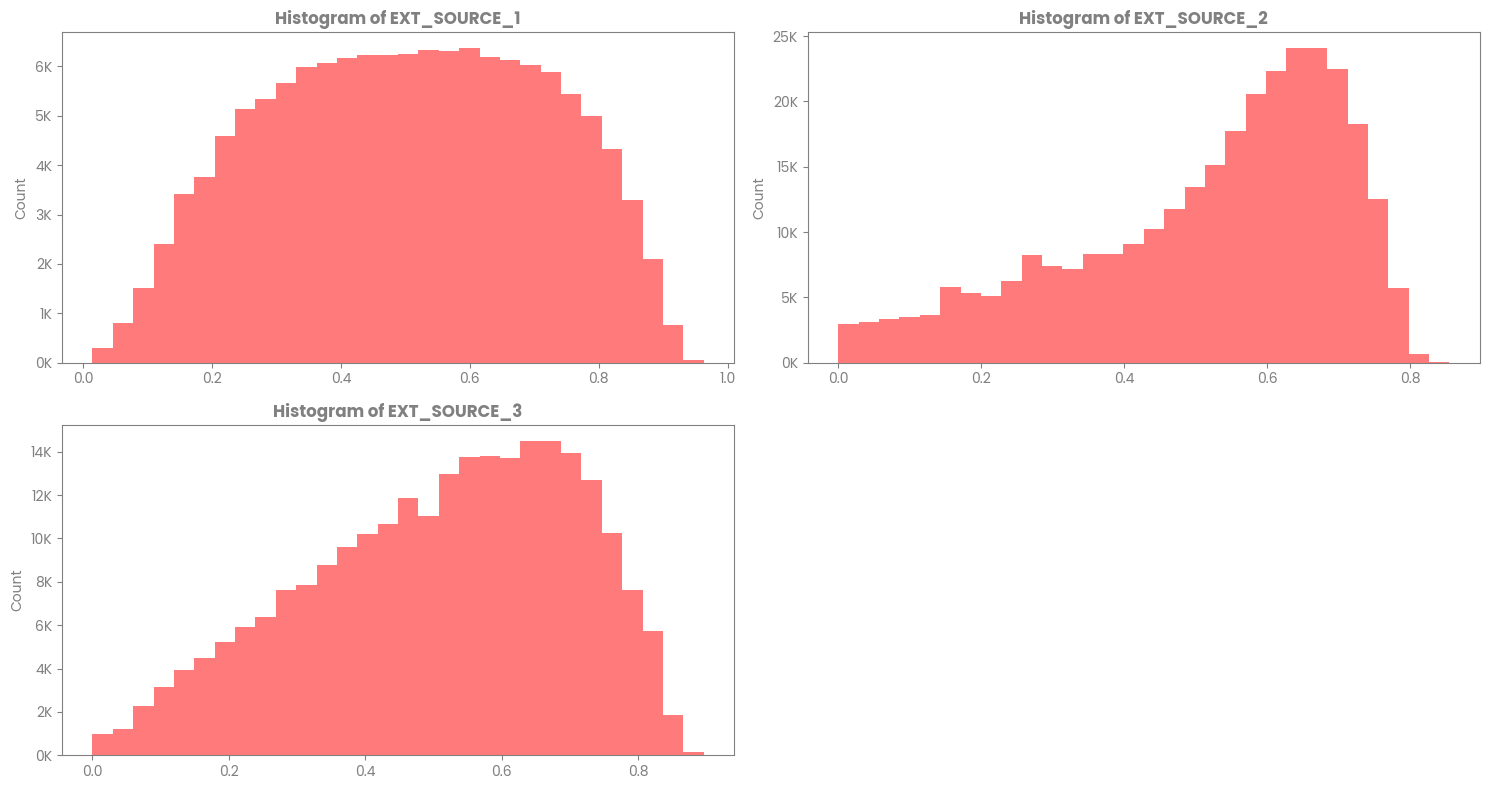

In [52]:
# Visualizing external sources characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(external_cols):
    ax = axes[i]
    sns.histplot(final_train[col].dropna(), kde=False, bins=30, ax=ax, edgecolor=None)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel("")
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

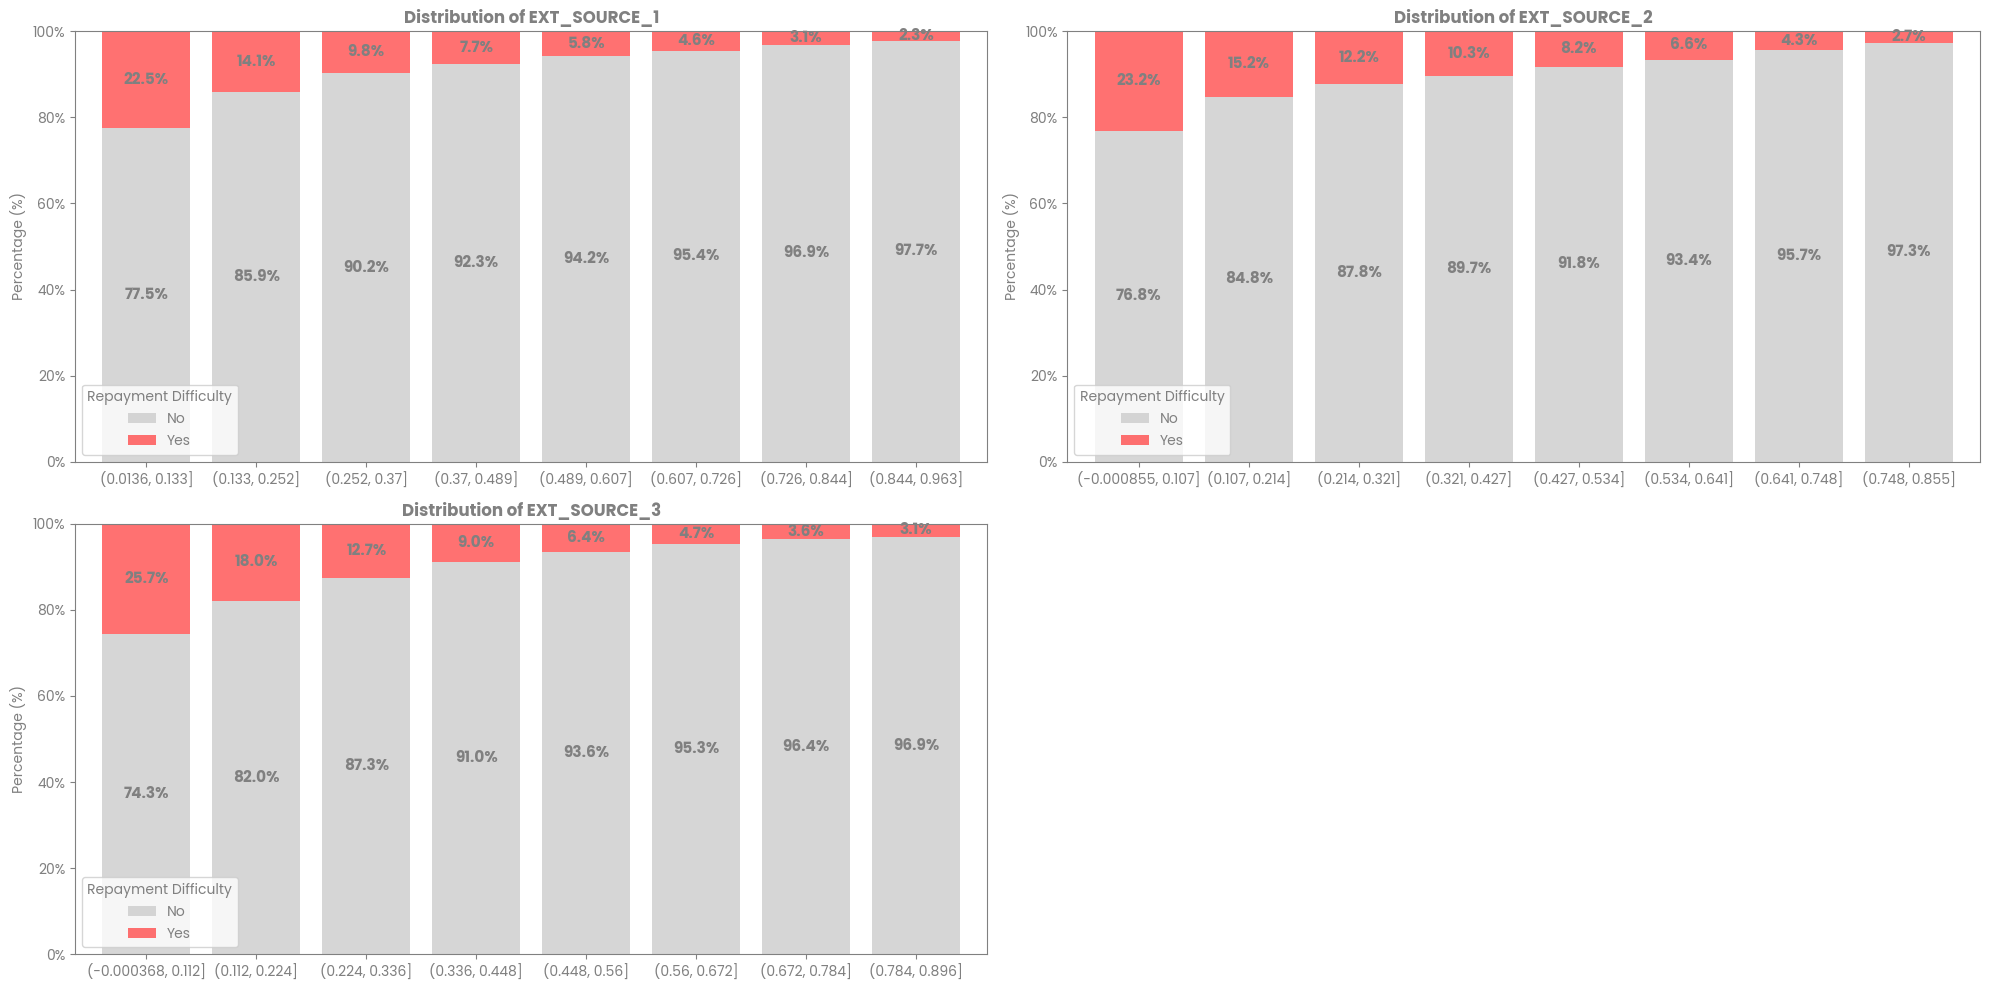

In [53]:
# Target distribution across external sources features
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(external_cols):
    ax = axes[i]

    data_col = final_train[col].dropna()
    bins = pd.cut(data_col, bins=8, duplicates='drop')
    cross_tab = pd.crosstab(bins, final_train.loc[data_col.index, 'TARGET'])
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    bars = cross_tab_pct.plot(kind='bar', stacked=True, ax=ax, alpha=0.8, width=0.8, color=['#CCCCCC', '#FF4D4D'])

    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f"{height:.1f}%", ha='center', va='center', fontsize=11, fontweight='bold', color='#808080')

    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 100)

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))

    legend = ax.legend(title='Repayment Difficulty', labels=['No', 'Yes'])
    legend.get_title().set_color('#808080')

    ax.tick_params(axis='x', rotation=0)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

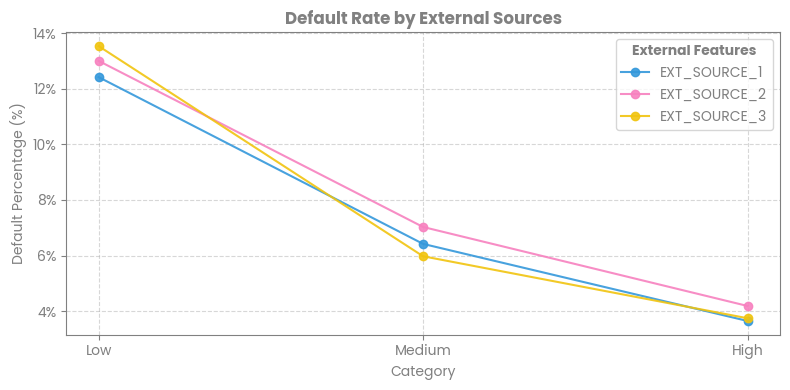

In [54]:
colors = ["#3498DB", "#F781BF", "#F1C40F"]
fig, ax = plt.subplots(figsize=(8, 4))

for idx, col in enumerate(external_cols):
    data_col = final_train[col].dropna()
    bins = pd.qcut(data_col, q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')

    cross_tab = pd.crosstab(bins, final_train.loc[data_col.index, 'TARGET'])
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

    default_rate = cross_tab_pct[1]

    ax.plot(default_rate.index, default_rate.values, marker='o', label=col, alpha=0.9, color=colors[idx % len(colors)])

ax.set_title("Default Rate by External Sources")
ax.set_xlabel("Category")
ax.set_ylabel("Default Percentage (%)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x)}%'))
ax.grid(True, linestyle='--', alpha=0.5)
legend = ax.legend(title="External Features")
legend.get_title().set_color("#808080")
legend.get_title().set_fontweight("bold")

plt.tight_layout()
plt.show()

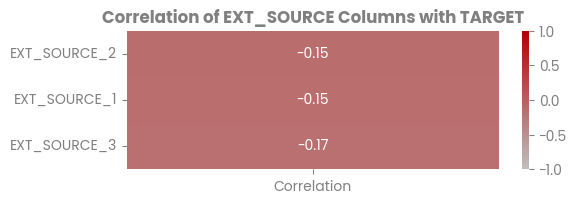

In [55]:
ext_corr = {}
for col in external_cols:
    corr, _ = spearmanr(final_train[[col, 'TARGET']].dropna()[col],
                        final_train[[col, 'TARGET']].dropna()['TARGET'])
    ext_corr[col] = corr

ext_corr_df = pd.DataFrame.from_dict(ext_corr, orient='index', columns=['Correlation'])
ext_corr_df = ext_corr_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(6, len(ext_corr_df)*0.6))
sns.heatmap(ext_corr_df, annot=True, cmap=cmap, vmin=-1, vmax=1)
plt.title('Correlation of EXT_SOURCE Columns with TARGET')
plt.show()

## **3.7. Bureau Analysis**

Credit Active Distribution:
CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64


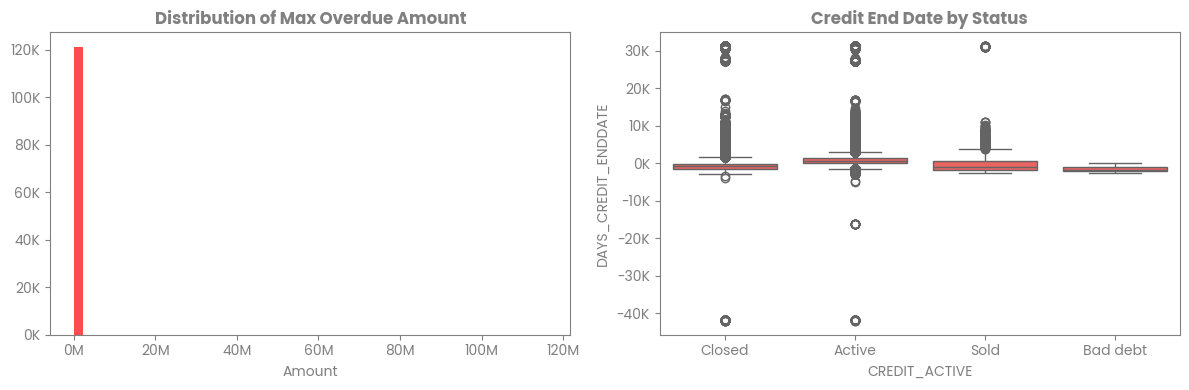

In [56]:
print("Credit Active Distribution:")
print(bureau_df['CREDIT_ACTIVE'].value_counts())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
bureau_df[bureau_df['AMT_CREDIT_MAX_OVERDUE'] > 0]['AMT_CREDIT_MAX_OVERDUE'].hist(bins=50)
plt.title('Distribution of Max Overdue Amount')
plt.xlabel('Amount')
plt.grid(False)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000_000)}M'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

plt.subplot(1, 2, 2)
sns.boxplot(data=bureau_df, x='CREDIT_ACTIVE', y='DAYS_CREDIT_ENDDATE')
plt.title('Credit End Date by Status')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

plt.tight_layout()
plt.show()

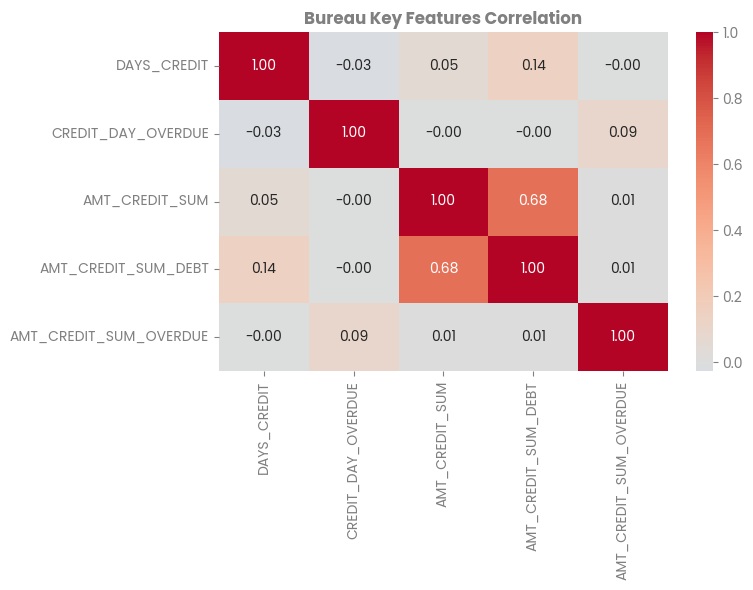

In [57]:
# Summary correlation heatmap for key numerical features
key_bureau_cols = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE']
bureau_corr = bureau_df[key_bureau_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(bureau_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Bureau Key Features Correlation')
plt.tight_layout()
plt.show()

## **3.8. Previous Applications Analysis**

Contract Status:
NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64



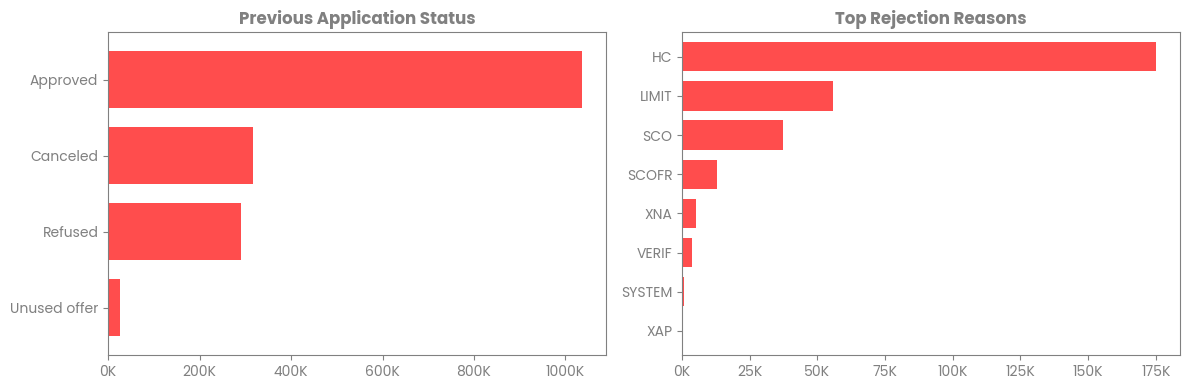

In [58]:
print("Contract Status:")
print(previous_app_df['NAME_CONTRACT_STATUS'].value_counts())
print()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
previous_app_df['NAME_CONTRACT_STATUS'].value_counts().sort_values(ascending=True).plot(kind='barh', width=0.75)
plt.title('Previous Application Status')
plt.xlabel('')
plt.ylabel('')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

plt.subplot(1, 2, 2)
reject_reasons = previous_app_df[previous_app_df['NAME_CONTRACT_STATUS'] == 'Refused']['CODE_REJECT_REASON'].value_counts().head(10)
reject_reasons.sort_values(ascending=True).plot(kind='barh', width=0.75)
plt.title('Top Rejection Reasons')
plt.xlabel('')
plt.ylabel('')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

plt.tight_layout()
plt.show()

## **3.9. POS Cash Analysis**

Contract Status Distribution:
NAME_CONTRACT_STATUS
Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: count, dtype: int64



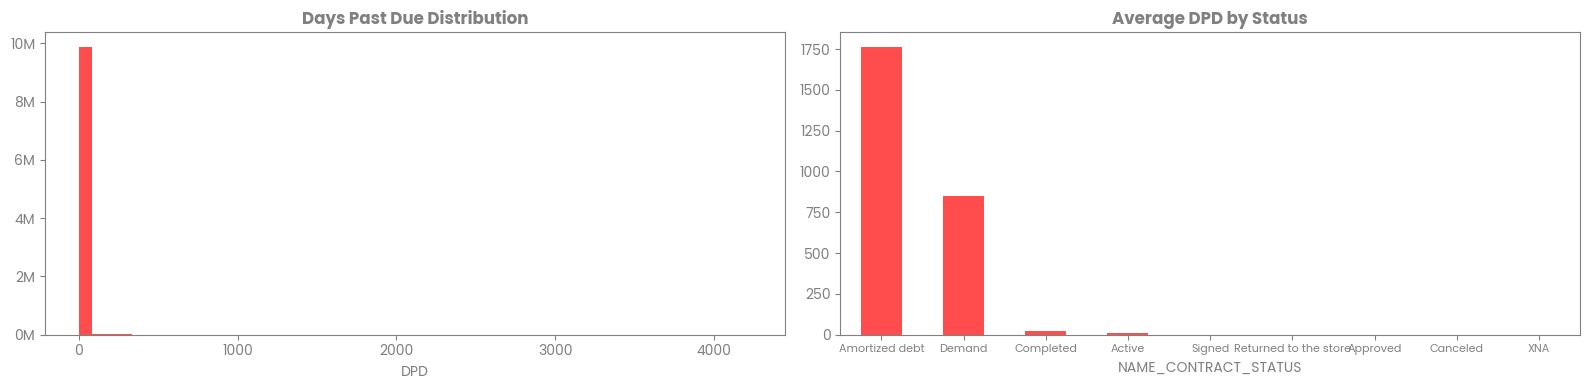

In [59]:
print("Contract Status Distribution:")
print(pos_cash_df['NAME_CONTRACT_STATUS'].value_counts())
print()

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
pos_cash_df['SK_DPD'].hist(bins=50)
plt.title('Days Past Due Distribution')
plt.xlabel('DPD')
plt.grid(False)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000_000)}M'))

plt.subplot(1, 2, 2)
avg_dpd = pos_cash_df.groupby('NAME_CONTRACT_STATUS')['SK_DPD'].mean().sort_values(ascending=False)
avg_dpd.plot(kind='bar')
plt.title('Average DPD by Status')
plt.xticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

## **3.10. Credit Analysis**

Contract Status:
NAME_CONTRACT_STATUS
Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: count, dtype: int64



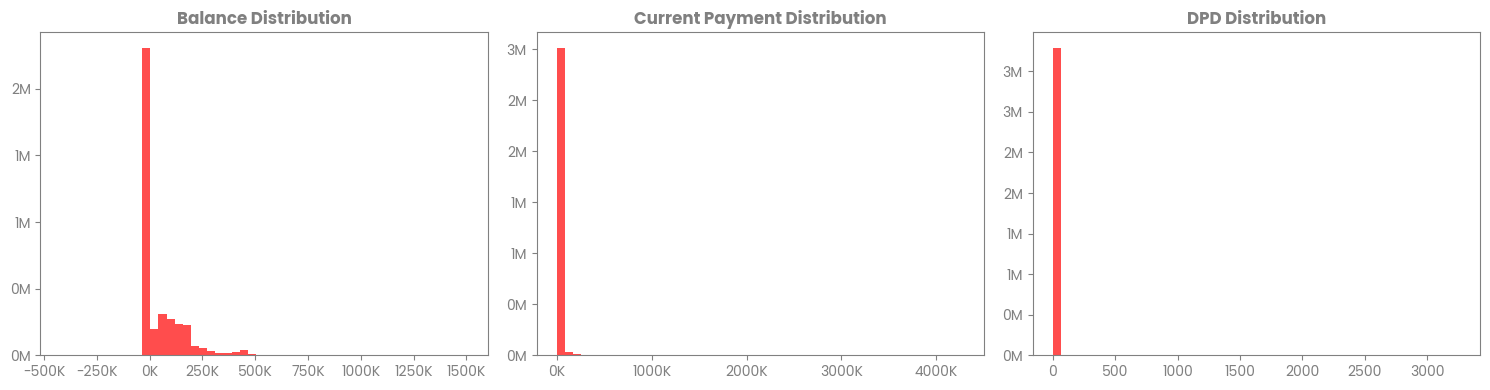

In [60]:
print("Contract Status:")
print(credit_card_df['NAME_CONTRACT_STATUS'].value_counts())
print()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
credit_card_df['AMT_BALANCE'].hist(bins=50)
plt.title('Balance Distribution')
plt.grid(False)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000_000)}M'))

plt.subplot(1, 3, 2)
credit_card_df['AMT_PAYMENT_CURRENT'].hist(bins=50)
plt.title('Current Payment Distribution')
plt.grid(False)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000_000)}M'))

plt.subplot(1, 3, 3)
credit_card_df['SK_DPD'].hist(bins=50)
plt.title('DPD Distribution')
plt.grid(False)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000_000)}M'))

plt.tight_layout()
plt.show()

## **3.11. Payment Ratio Analysis**

Payment Ratio Stats:
count    1.360249e+07
mean     1.278327e+00
std      1.328507e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.942500e+05
Name: PAYMENT_RATIO, dtype: float64



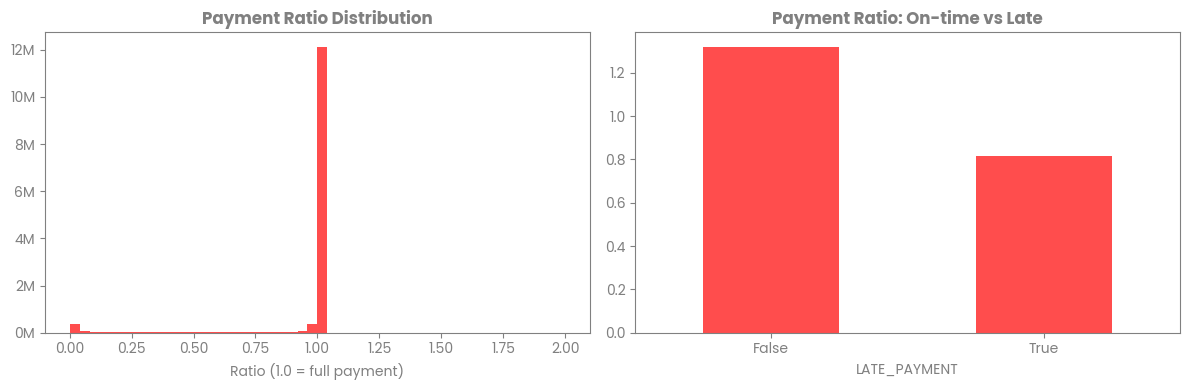

In [61]:
print(f"Payment Ratio Stats:")
print(installments_df['PAYMENT_RATIO'].describe())
print()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
installments_df['PAYMENT_RATIO'].hist(bins=50, range=(0, 2))
plt.title('Payment Ratio Distribution')
plt.xlabel('Ratio (1.0 = full payment)')
plt.grid(False)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000_000)}M'))

plt.subplot(1, 2, 2)
installments_df['LATE_PAYMENT'] = installments_df['DAYS_ENTRY_PAYMENT'] > installments_df['DAYS_INSTALMENT']
installments_df.groupby('LATE_PAYMENT')['PAYMENT_RATIO'].mean().plot(kind='bar')
plt.title('Payment Ratio: On-time vs Late')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## **3.12. Top Features**

In [62]:
# Calculate correlation only with numeric columns
numeric_cols = final_train.select_dtypes(include=[np.number]).columns
corr_with_target = final_train[numeric_cols].corr()['TARGET'].abs().sort_values(ascending=False)
corr_with_target = corr_with_target.drop('TARGET')

threshold = 0.05
filtered_corr = corr_with_target[corr_with_target >= threshold]

print(f"Columns with correlation >= {threshold}:")
for col, corr_val in filtered_corr.items():
    print(f"{col:40} | {corr_val:.4f}")

Columns with correlation >= 0.05:
EXT_SOURCE_3                             | 0.1789
EXT_SOURCE_2                             | 0.1605
EXT_SOURCE_1                             | 0.1553
BUREAU_DAYS_CREDIT_MEAN                  | 0.0840
DAYS_BIRTH                               | 0.0782
AGE_YEARS                                | 0.0782
YEARS_EMPLOYED                           | 0.0750
DAYS_EMPLOYED_BIN                        | 0.0750
PREV_REFUSED_COUNT                       | 0.0648
REGION_RATING_CLIENT_W_CITY              | 0.0609
REGION_RATING_CLIENT                     | 0.0589
DAYS_LAST_PHONE_CHANGE                   | 0.0552
DAYS_ID_PUBLISH                          | 0.0515
REG_CITY_NOT_WORK_CITY                   | 0.0510


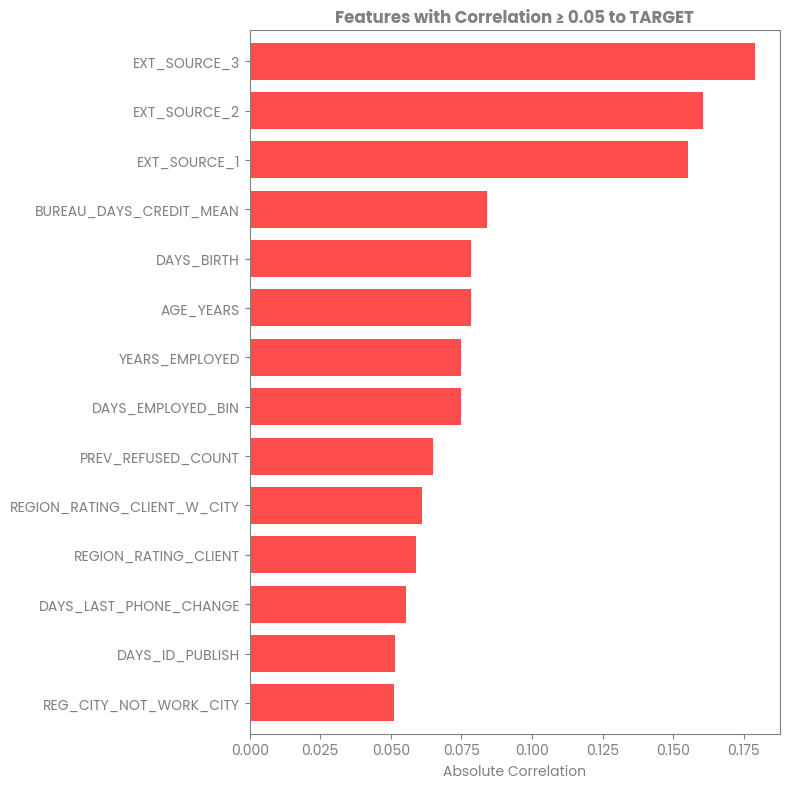

In [63]:
# Plot correlation
plt.figure(figsize=(8, 8))
filtered_corr.sort_values(ascending=True).plot(kind='barh', width=0.75)
plt.title('Features with Correlation ≥ 0.05 to TARGET')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

In [64]:
# Calculate Cramér's V between categorical features and the target
categorical_cols = final_train.select_dtypes(include='object').columns
cramers_results = {}

for col in categorical_cols:
    confusion_matrix = pd.crosstab(final_train[col], final_train['TARGET'])

    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    cramers_results[col] = cramers_v

threshold = 0.05
filtered_cramers = {k: v for k, v in cramers_results.items() if v >= threshold}

print(f"Categorical columns with Cramér's V >= {threshold}:")
for col, val in sorted(filtered_cramers.items(), key=lambda x: x[1], reverse=True):
    print(f"{col:40} | {val:.4f}")

Categorical columns with Cramér's V >= 0.05:
EMPLOYED_BIN_Q                           | 0.0878
OCCUPATION_TYPE                          | 0.0810
ORGANIZATION_TYPE                        | 0.0710
NAME_INCOME_TYPE                         | 0.0637
CODE_GENDER                              | 0.0547


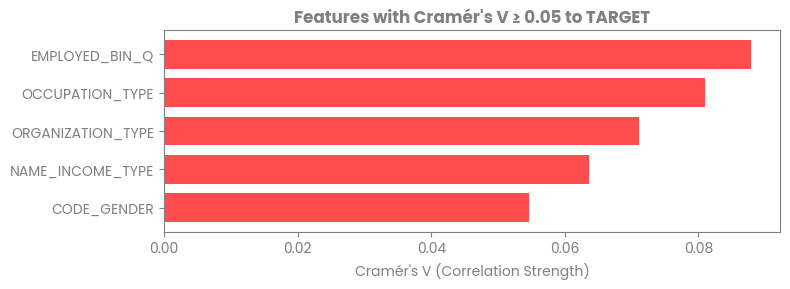

In [65]:
# Plot Cramér's V values (≥ 0.05) for categorical features against the target
cramers_series = pd.Series(filtered_cramers)
plt.figure(figsize=(8, 3))
cramers_series.sort_values(ascending=True).plot(kind='barh', width=0.75)
plt.title("Features with Cramér's V ≥ 0.05 to TARGET")
plt.xlabel("Cramér's V (Correlation Strength)")
plt.tight_layout()
plt.show()